House Price Prediction - Advanced regression Assignment
------------------------------------------------------------------------------------------------------
The solution is divided into the following sections:

- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation
- Observation and inference

## Step 1: Reading and Understanding the Data


In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


from scipy import stats
from scipy.stats import norm

In [2]:
def displayLables(ax, d=None):
    plt.margins(0.2, 0.2)
    rects = ax.patches
    i = 0
    locs, labels = plt.xticks() 
    counts = {}
    if not d is None:
        for key, value in d.items():
            counts[str(key)] = value

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if d is None:
            label = "{:.1f}%".format(y_value)
        else:
            try:
                label = "{:.1f}%".format(y_value) + "\nof " + str(counts[str(labels[i].get_text())])
            except:
                label = "{:.1f}%".format(y_value)
        
        i = i+1

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


In [3]:
# Function to plot percentage of a variable in the entire dataset 
def plotByPercentages(dataframe, by, sortbyindex=False):
    plt.subplot(1, 2, 1)
    values = (house_data[by].value_counts(normalize=True)*100)
    if sortbyindex:
        values = values.sort_index()
    ax = values.plot.bar(color=sns.color_palette('husl', 16))
    ax.set_ylabel('% in dataset', fontsize=16)
    ax.set_xlabel(by, fontsize=12)
    displayLables(ax)
    plt.subplot(1, 2, 1)
    displayLables(ax)

### Data Sourcing

In [4]:
# Read the data from csv file

house_data = pd.read_csv("train.csv", encoding = 'utf-8')
house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# check the shape of dataframe

house_data.shape

(1460, 81)

In [6]:
# describe the columns of dataframe

house_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
# Check the columns information 
print(house_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
# Checking and dropping duplicated records(if any)

house_data = house_data.drop_duplicates()

In [9]:
house_data.shape

(1460, 81)

## Step 2: Data Cleaning and Manipulation

### Removing/Imputing NaN values in Categorical attributes

In [10]:
# Check null values if any(column wise: missing value percentage)

missing_val_cols_prcnt = round(100*house_data.isnull().sum()/len(house_data.index),2)
missing = pd.DataFrame({'percent' : missing_val_cols_prcnt[missing_val_cols_prcnt!=0]})
missing.sort_values(by ='percent', ascending=False, inplace = True)
missing

,percent
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageType,5.55
GarageYrBlt,5.55
GarageFinish,5.55
GarageQual,5.55


In [11]:
# Considering the aspect of 'meaningful missing'. 
# Replace nulls with 'None' where null implies absence of feature (from data dictionary)

cat_null_obj_cols = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                     'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                     'GarageCond', 'PoolQC', 'Fence', 'MiscFeature','Electrical']
for column in cat_null_obj_cols:
    house_data[column]= house_data[column].fillna('None')


In [12]:
# Inspecting null values agian in the categorical columns (only object types).

cat_obj_null_cols = house_data.select_dtypes(include='object')   #Retaining only object types categorical columns
missing_cat_obj_null_prcnt = round(100*cat_obj_null_cols.isnull().sum()/len(cat_obj_null_cols.index),2)
missing_cat_obj_null_prcnt = missing_cat_obj_null_prcnt[missing_cat_obj_null_prcnt!=0]
missing_cat_obj_null_prcnt

Series([], dtype: float64)

No more null values in the categorical variables

### Remove categorical attributes that have more than 80% data associated to one value.

   We will remove any columns having greater than 80% of single valueas those column would be skewed to one value

In [13]:
# Drop the following columns that have more than 80% values associated to a specific value
# Method to get the column names that have count of one value more than 80%

def getHighCategoricalValueCounts():
    column = []
    categorical_columns = house_data.select_dtypes(include=['object'])
    for col in (categorical_columns):
        if(house_data[col].value_counts().max() > int(80*len(house_data.index)/100)):
            column.append(col)
    return column

columnsToBeRemoved = getHighCategoricalValueCounts()

print(columnsToBeRemoved)

['Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [14]:
# Dropping columns with skewed data (object type categorical variables)

house_data.drop(columnsToBeRemoved, axis = 1, inplace = True)

house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003.0,RFn,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976.0,RFn,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001.0,RFn,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998.0,Unf,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000.0,RFn,3,836,192,84,0,0,0,0,0,12,2008,250000


In [15]:
house_data.shape

(1460, 57)

### EDA - Categorical Variables Analysis

C (all)      10
RH           16
FV           65
RM          218
RL         1151
Name: MSZoning, dtype: int64




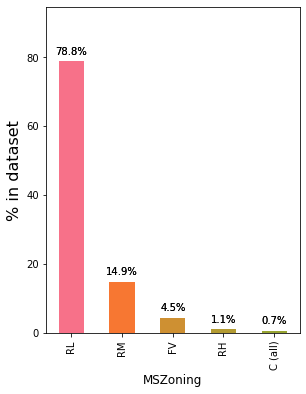

In [16]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'MSZoning')
series = house_data.MSZoning.value_counts(dropna = False)

print(series.sort_values())
print('\n')

IR3     10
IR2     41
IR1    484
Reg    925
Name: LotShape, dtype: int64




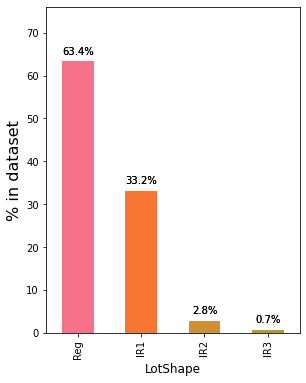

In [17]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'LotShape')
series = house_data.LotShape.value_counts(dropna = False)

print(series.sort_values())
print('\n')

FR3           4
FR2          47
CulDSac      94
Corner      263
Inside     1052
Name: LotConfig, dtype: int64




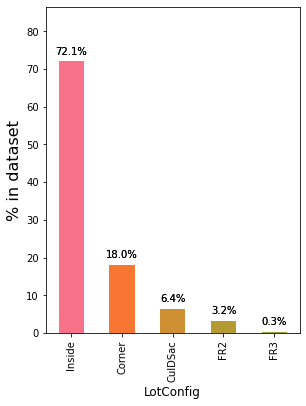

In [18]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'LotConfig')
series = house_data.LotConfig.value_counts(dropna = False)

print(series.sort_values())
print('\n')

Fa     39
Ex    100
Gd    586
TA    735
Name: KitchenQual, dtype: int64




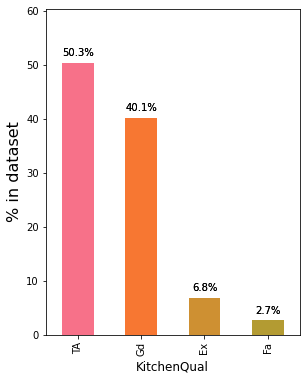

In [19]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'KitchenQual')
series = house_data.KitchenQual.value_counts(dropna = False)

print(series.sort_values())
print('\n')

Po       20
Ex       24
Fa       33
TA      313
Gd      380
None    690
Name: FireplaceQu, dtype: int64




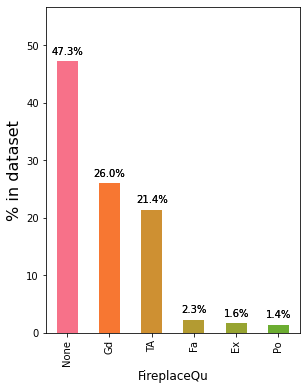

In [20]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'FireplaceQu')
series = house_data.FireplaceQu.value_counts(dropna = False)

print(series.sort_values())
print('\n')

Shed          2
Mansard       7
Gambrel      11
Flat         13
Hip         286
Gable      1141
Name: RoofStyle, dtype: int64




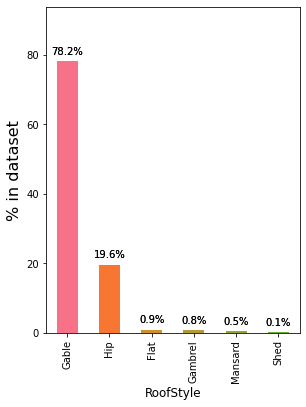

In [21]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'RoofStyle')
series = house_data.RoofStyle.value_counts(dropna = False)

print(series.sort_values())
print('\n')

2Types       6
CarPort      9
Basment     19
None        81
BuiltIn     88
Detchd     387
Attchd     870
Name: GarageType, dtype: int64




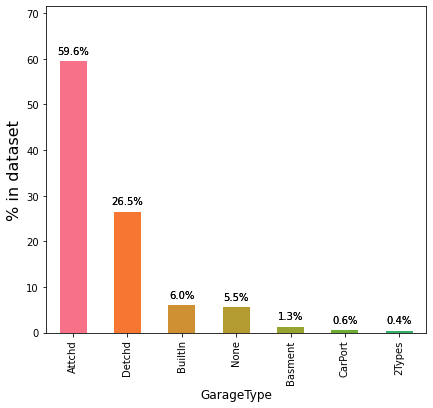

In [22]:
plt.figure(figsize=(15,6))
plotByPercentages(house_data, 'GarageType')
series = house_data.GarageType.value_counts(dropna = False)

print(series.sort_values())
print('\n')

None     81
Fin     352
RFn     422
Unf     605
Name: GarageFinish, dtype: int64




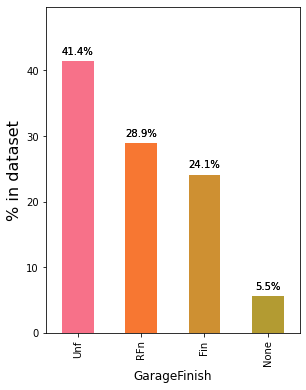

In [23]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'GarageFinish')
series = house_data.GarageFinish.value_counts(dropna = False)

print(series.sort_values())
print('\n')

BrkCmn      15
Stone      128
BrkFace    445
None       872
Name: MasVnrType, dtype: int64




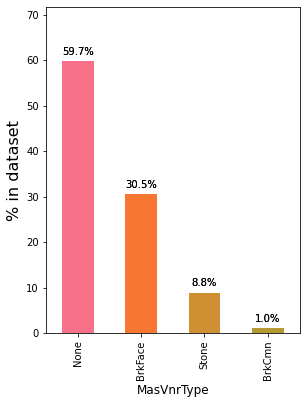

In [24]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'MasVnrType')
series = house_data.MasVnrType.value_counts(dropna = False)

print(series.sort_values())
print('\n')

Fa     14
Ex     52
Gd    488
TA    906
Name: ExterQual, dtype: int64




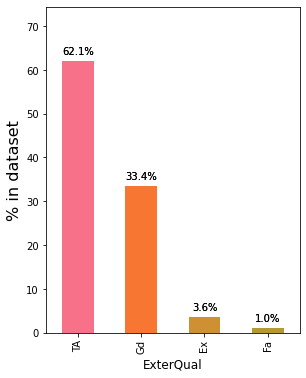

In [25]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'ExterQual')
series = house_data.ExterQual.value_counts(dropna = False)

print(series.sort_values())
print('\n')

Wood        3
Stone       6
Slab       24
BrkTil    146
CBlock    634
PConc     647
Name: Foundation, dtype: int64




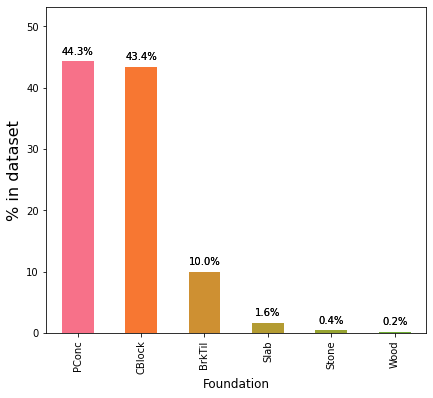

In [26]:
plt.figure(figsize=(15,6))
plotByPercentages(house_data, 'Foundation')
series = house_data.Foundation.value_counts(dropna = False)

print(series.sort_values())
print('\n')

Fa       35
None     37
Ex      121
Gd      618
TA      649
Name: BsmtQual, dtype: int64




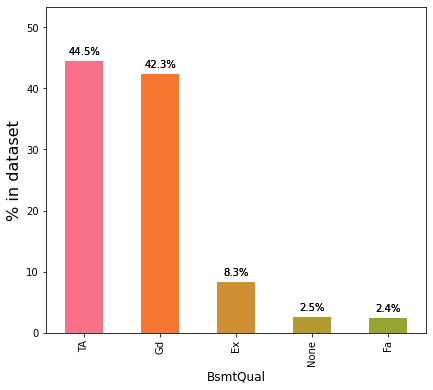

In [27]:
plt.figure(figsize=(15,6))
plotByPercentages(house_data, 'BsmtQual')
series = house_data.BsmtQual.value_counts(dropna = False)

print(series.sort_values())
print('\n')

None     38
Mn      114
Gd      134
Av      221
No      953
Name: BsmtExposure, dtype: int64




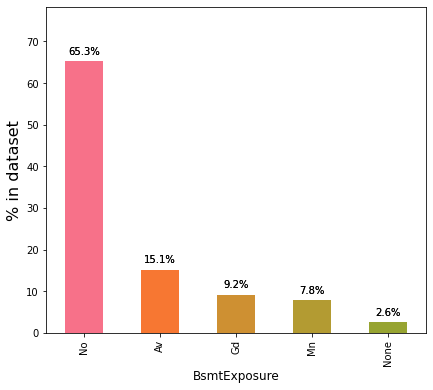

In [28]:
plt.figure(figsize=(15,6))
plotByPercentages(house_data, 'BsmtExposure')
series = house_data.BsmtExposure.value_counts(dropna = False)

print(series.sort_values())
print('\n')

None     37
LwQ      74
Rec     133
BLQ     148
ALQ     220
GLQ     418
Unf     430
Name: BsmtFinType1, dtype: int64




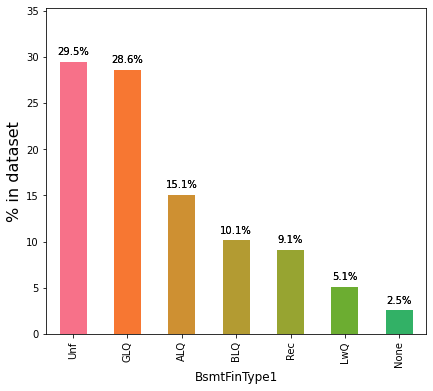

In [29]:
plt.figure(figsize=(15,6))
plotByPercentages(house_data, 'BsmtFinType1')
series = house_data.BsmtFinType1.value_counts(dropna = False)

print(series.sort_values())
print('\n')

Po      1
Fa     49
Gd    241
TA    428
Ex    741
Name: HeatingQC, dtype: int64




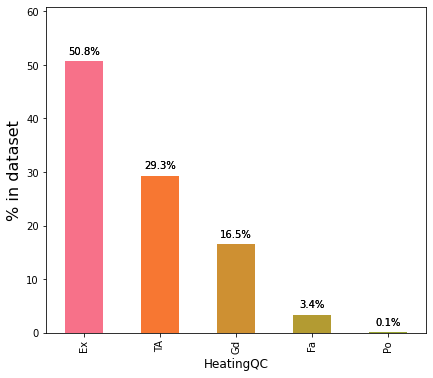

In [30]:
plt.figure(figsize=(15,6))
plotByPercentages(house_data, 'HeatingQC')
series = house_data.HeatingQC.value_counts(dropna = False)

print(series.sort_values())
print('\n')

Blueste      2
NPkVill      9
Veenker     11
BrDale      16
Blmngtn     17
MeadowV     17
SWISU       25
StoneBr     25
ClearCr     28
IDOTRR      37
Timber      38
NoRidge     41
Mitchel     49
Crawfor     51
BrkSide     58
SawyerW     59
NWAmes      73
Sawyer      74
NridgHt     77
Gilbert     79
Somerst     86
Edwards    100
OldTown    113
CollgCr    150
NAmes      225
Name: Neighborhood, dtype: int64




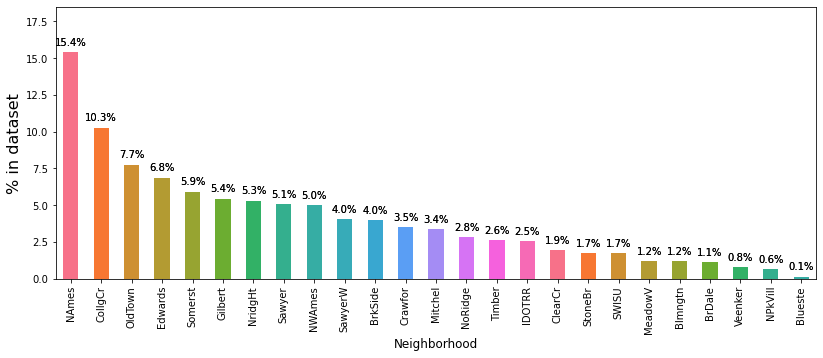

In [31]:
plt.figure(figsize=(30,5))
plotByPercentages(house_data, 'Neighborhood')
series = house_data.Neighborhood.value_counts(dropna = False)

print(series.sort_values())
print('\n')

2.5Fin      8
2.5Unf     11
1.5Unf     14
SFoyer     37
SLvl       65
1.5Fin    154
2Story    445
1Story    726
Name: HouseStyle, dtype: int64




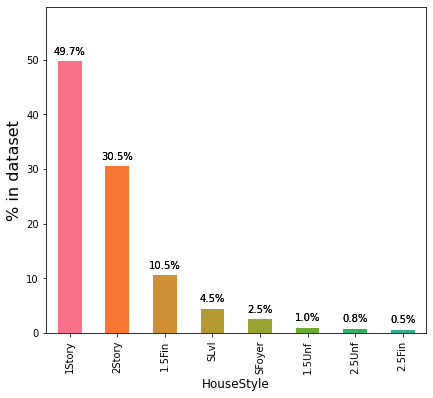

In [32]:
plt.figure(figsize=(15,6))
plotByPercentages(house_data, 'HouseStyle')
series = house_data.HouseStyle.value_counts(dropna = False)

print(series.sort_values())
print('\n')

AsphShn      1
ImStucc      1
CBlock       1
BrkComm      2
Stone        2
AsbShng     20
Stucco      25
WdShing     26
BrkFace     50
CemntBd     61
Plywood    108
Wd Sdng    206
MetalSd    220
HdBoard    222
VinylSd    515
Name: Exterior1st, dtype: int64




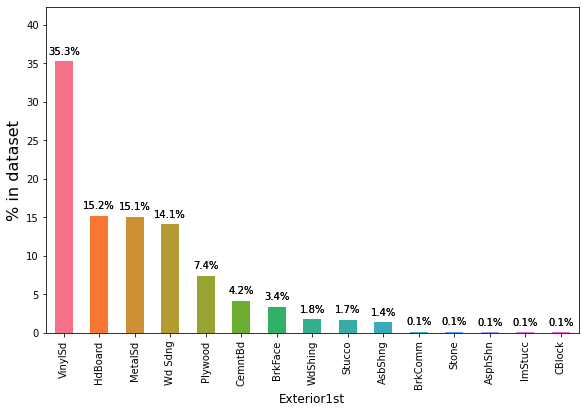

In [33]:
plt.figure(figsize=(21,6))
plotByPercentages(house_data, 'Exterior1st')
series = house_data.Exterior1st.value_counts(dropna = False)

print(series.sort_values())
print('\n')

Other        1
CBlock       1
AsphShn      3
Stone        5
Brk Cmn      7
ImStucc     10
AsbShng     20
BrkFace     25
Stucco      26
Wd Shng     38
CmentBd     60
Plywood    142
Wd Sdng    197
HdBoard    207
MetalSd    214
VinylSd    504
Name: Exterior2nd, dtype: int64




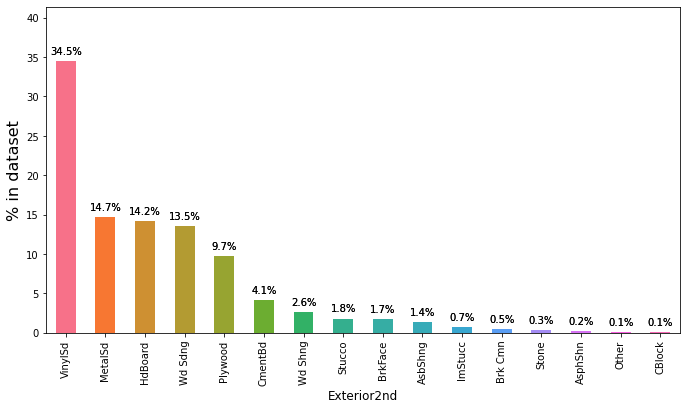

In [34]:
plt.figure(figsize=(25,6))
plotByPercentages(house_data, 'Exterior2nd')
series = house_data.Exterior2nd.value_counts(dropna = False)

print(series.sort_values())
print('\n')

#### Observations:

    Most preferred choices:
    - 'MSZoning' zone of the sale:'RL'(Residential Low Density) followed by 'RM'(Residential Medium Density).
    - 'LotShape': Reg(Regular) type
    - 'LotConfig': Inside(Inside lot)
    -  No significant preference w.r.t following features:
        -(i) FireplaceQu (Quality), MasVnrType: 'None'
        -(ii) KitchenQual (Quality), ExterQual (Quality of exterior material), 
        BsmtQual (Height of basement):'TA'(Typical/Average)
    - 'RoofStyle': 'Gable'
    - 'GarageType': Attached
    - 'GarageFinish': Unfinished
    - 'Foundation': Poured Concrete
    - 'Basement Exposure': No Exposure
    - 'BsmtFinType1' Rating of Basement Fin. Area: Good Living Quarters and Unfinished
    - 'HeatingQC': Excellent
    - 'Neighborhood': North Ames, followed by College Creek
    - 'HouseStyle': One story, followed by Two story.
    - 'Exterior1st' (Exterior covering on the house) and 'Exterior2nd' (if more than one material on exterior):
    Vinyl Siding, followed by Metal Siding


### Removing null values in Numerical attributes

In [35]:
# check the null values in the numerical data

numeric_null_cols = house_data.select_dtypes(include=['int64','float64','int32','float32'])   
missing_numeric_null_prcnt = round(100*numeric_null_cols.isnull().sum()/len(numeric_null_cols.index),2)
missing_numeric_null_prcnt = pd.DataFrame({'percent' : missing_numeric_null_prcnt[missing_numeric_null_prcnt!=0]})
missing_numeric_null_prcnt.sort_values(by ='percent', ascending=False, inplace = True)

missing_numeric_null_prcnt

,percent
LotFrontage,17.74
GarageYrBlt,5.55
MasVnrArea,0.55


In [36]:
# Impute the null values with median values for LotFrontage and MasVnrArea columns

house_data['LotFrontage'] = house_data['LotFrontage'].replace(np.nan, house_data['LotFrontage'].median())
house_data['MasVnrArea'] = house_data['MasVnrArea'].replace(np.nan, house_data['MasVnrArea'].median())

In [37]:
# Setting the null values with 0 for GarageYrBlt for now as we would be handling this column further below

house_data['GarageYrBlt'] = house_data['GarageYrBlt'].fillna(0)
house_data['GarageYrBlt'] = house_data['GarageYrBlt'].astype(int)

In [38]:
# Recheck null values in the numeric columns.

numeric_null_cols = house_data.select_dtypes(include=['int64','float64','int32','float32'])   #Retaining only int and float data types for numeric columns
missing_numeric_null_prcnt = round(100*numeric_null_cols.isnull().sum()/len(numeric_null_cols.index),2)
missing_numeric_null_prcnt = missing_numeric_null_prcnt[missing_numeric_null_prcnt!=0]
missing_numeric_null_prcnt

Series([], dtype: float64)

No null values are present in the numeric columns of the dataset.

### Derived Features

In [39]:
# Create a new column named IsRemodelled - This column would determine whether the house has been remodelled 
# or not based on the difference between remodelled and built years

def checkIfRemodeledHouse(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return 0
    elif(row['YearBuilt'] < row['YearRemodAdd']):
        return 1
    else:
        return 2
    
house_data['IsRemodelled'] = house_data.apply(checkIfRemodeledHouse, axis=1)
house_data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,IsRemodelled
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,0,2,2008,208500,0
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,0,5,2007,181500,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,0,9,2008,223500,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,0,2,2006,140000,1
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,0,12,2008,250000,0


In [40]:
# Verify no wrong entries with value '2'. Hence, 0 if not remodelled and 1 if remodelled.

house_data.IsRemodelled.value_counts()

0    764
1    696
Name: IsRemodelled, dtype: int64

In [41]:
# Create a new column named BuiltOrRemodelledAge and determine the age of the building at the time of selling

def getAgeForBuiltOrRemodeledHouse(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return row['YrSold'] - row['YearBuilt']
    else:
        return row['YrSold'] - row['YearRemodAdd']
       
house_data['BuiltOrRemodelAge'] = house_data.apply(getAgeForBuiltOrRemodeledHouse, axis=1)
house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,IsRemodelled,BuiltOrRemodelAge
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,0,2,2008,208500,0,5
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,0,5,2007,181500,0,31
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,0,9,2008,223500,1,6
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,0,2,2006,140000,1,36
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,0,12,2008,250000,0,8


In [42]:
# Create a new column which would indicate if the Garage is old or new.
# Garage Yr Built less than 2000 will be considered as old (0) else new(1). 
# For GarageYrBuilt , where we have imputed the value as 0 will also be treated as old.

def getConstructionPeriodForGarage(row):
    if row == 0:
        return 0
    elif row >= 1900 and row < 2000:        
        return 0
    else:   
        return 1
    
house_data['OldOrNewGarage'] = house_data['GarageYrBlt'].apply(getConstructionPeriodForGarage)
house_data.head() 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,0,2,2008,208500,0,5,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,0,5,2007,181500,0,31,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,0,9,2008,223500,1,6,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,0,2,2006,140000,1,36,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,0,12,2008,250000,0,8,1


In [43]:
# Since we have created new features from YearBuilt, YearRemodAdd, YrSold and GarageYrBlt, 
# we can drop these columns as we would only be using the derived columns for further analysis

house_data.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1, inplace = True)


### Remove numerical attributes that have more than 80% data associated to one value.
We will remove any column that has one value repeating 80% as this column would be skewed to one value

In [44]:
# Drop the following columns that have more than 80% values associated to a specific value
# We will also drop MoSold as we will not be using that for further analysis

def getHighNumericalValueCounts():
    column = []
    numerical_columns = house_data.select_dtypes(include=['int64', 'float'])
    for col in (numerical_columns):
        if(house_data[col].value_counts().max() > int(80*len(house_data.index)/100)):
            column.append(col)
    return column

columnsToBeRemoved = getHighNumericalValueCounts()
print("columnsToBeRemoved: " , columnsToBeRemoved)


columnsToBeRemoved:  ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [45]:
house_data.drop(columnsToBeRemoved, axis = 1, inplace = True)

house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,None,Attchd,RFn,2,548,0,61,2,208500,0,5,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,TA,Attchd,RFn,2,460,298,0,5,181500,0,31,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,6,1,TA,Attchd,RFn,2,608,0,42,9,223500,1,6,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,961,756,1717,1,1,0,3,Gd,7,1,Gd,Detchd,Unf,3,642,0,35,2,140000,1,36,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,1145,1053,2198,1,2,1,4,Gd,9,1,TA,Attchd,RFn,3,836,192,84,12,250000,0,8,1


In [46]:
percent_missing = round(100*(house_data.isnull().sum()/len(house_data.index)), 2)
print(percent_missing)

Id                   0.0
MSSubClass           0.0
MSZoning             0.0
LotFrontage          0.0
LotArea              0.0
LotShape             0.0
LotConfig            0.0
Neighborhood         0.0
HouseStyle           0.0
OverallQual          0.0
OverallCond          0.0
RoofStyle            0.0
Exterior1st          0.0
Exterior2nd          0.0
MasVnrType           0.0
MasVnrArea           0.0
ExterQual            0.0
Foundation           0.0
BsmtQual             0.0
BsmtExposure         0.0
BsmtFinType1         0.0
BsmtFinSF1           0.0
BsmtUnfSF            0.0
TotalBsmtSF          0.0
HeatingQC            0.0
1stFlrSF             0.0
2ndFlrSF             0.0
GrLivArea            0.0
BsmtFullBath         0.0
FullBath             0.0
HalfBath             0.0
BedroomAbvGr         0.0
KitchenQual          0.0
TotRmsAbvGrd         0.0
Fireplaces           0.0
FireplaceQu          0.0
GarageType           0.0
GarageFinish         0.0
GarageCars           0.0
GarageArea           0.0


There are no null values in the dataset

In [47]:
house_data.shape

(1460, 47)

### EDA - Quantitative Variables Analysis

2      52
1      58
12     59
9      63
11     79
10     89
3     106
8     122
4     141
5     204
7     234
6     253
Name: MoSold, dtype: int64




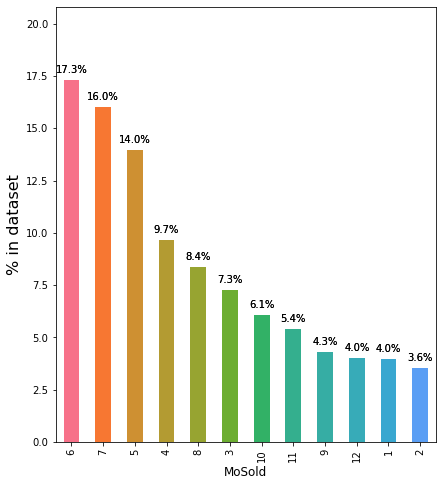

In [48]:
plt.figure(figsize=(15,8))
plotByPercentages(house_data, 'MoSold')
series = house_data.MoSold.value_counts(dropna = False)

print(series.sort_values())
print('\n')

40       4
180     10
45      12
75      16
85      20
190     30
90      52
80      58
70      60
160     63
30      69
120     87
50     144
60     299
20     536
Name: MSSubClass, dtype: int64




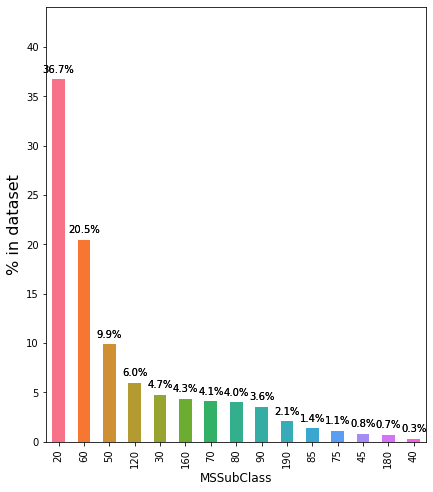

In [49]:
plt.figure(figsize=(15,8))
plotByPercentages(house_data, 'MSSubClass')
series = house_data.MSSubClass.value_counts(dropna = False)

print(series.sort_values())
print('\n')

1      1
2      5
9     22
3     25
4     57
8     72
7    205
6    252
5    821
Name: OverallCond, dtype: int64




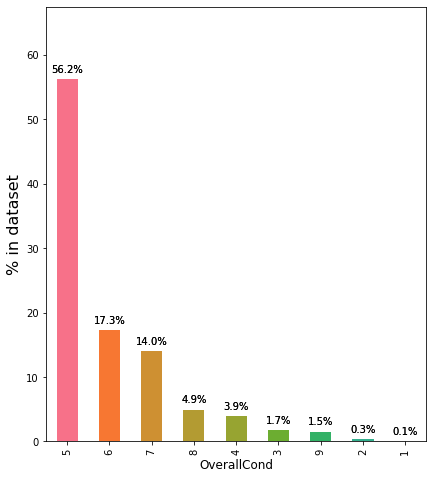

In [50]:
plt.figure(figsize=(15,8))
plotByPercentages(house_data, 'OverallCond')
series = house_data.OverallCond.value_counts(dropna = False)

print(series.sort_values())
print('\n')

1       2
2       3
10     18
3      20
9      43
4     116
8     168
7     319
6     374
5     397
Name: OverallQual, dtype: int64




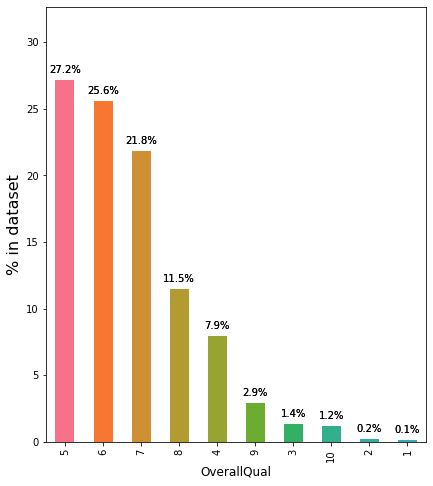

In [51]:
plt.figure(figsize=(15,8))
plotByPercentages(house_data, 'OverallQual')
series = house_data.OverallQual.value_counts(dropna = False)

print(series.sort_values())
print('\n')

3      1
2     15
1    588
0    856
Name: BsmtFullBath, dtype: int64




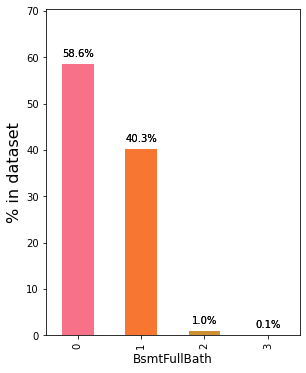

In [52]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'BsmtFullBath')
series = house_data.BsmtFullBath.value_counts(dropna = False)

print(series.sort_values())
print('\n')

0      9
3     33
1    650
2    768
Name: FullBath, dtype: int64




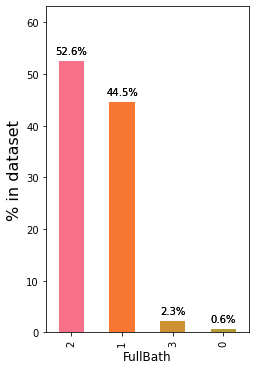

In [53]:
plt.figure(figsize=(8,6))
plotByPercentages(house_data, 'FullBath')
series = house_data.FullBath.value_counts(dropna = False)

print(series.sort_values())
print('\n')

2     12
1    535
0    913
Name: HalfBath, dtype: int64




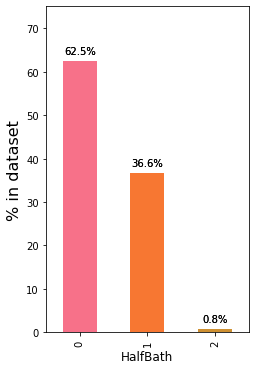

In [54]:
plt.figure(figsize=(8,6))
plotByPercentages(house_data, 'HalfBath')
series = house_data.HalfBath.value_counts(dropna = False)

print(series.sort_values())
print('\n')

8      1
0      6
6      7
5     21
1     50
4    213
2    358
3    804
Name: BedroomAbvGr, dtype: int64




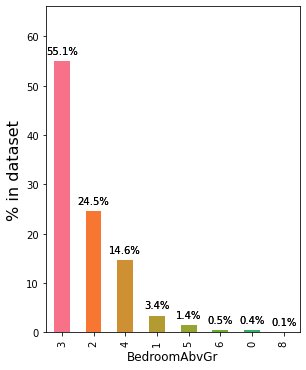

In [55]:
plt.figure(figsize=(10,6))
plotByPercentages(house_data, 'BedroomAbvGr')
series = house_data.BedroomAbvGr.value_counts(dropna = False)

print(series.sort_values())
print('\n')

2       1
14      1
12     11
3      17
11     18
10     47
9      75
4      97
8     187
5     275
7     329
6     402
Name: TotRmsAbvGrd, dtype: int64




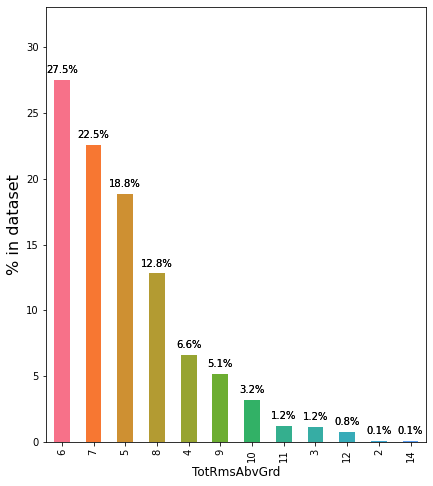

In [56]:
plt.figure(figsize=(15,8))
plotByPercentages(house_data, 'TotRmsAbvGrd')
series = house_data.TotRmsAbvGrd.value_counts(dropna = False)

print(series.sort_values())
print('\n')

3      5
2    115
1    650
0    690
Name: Fireplaces, dtype: int64




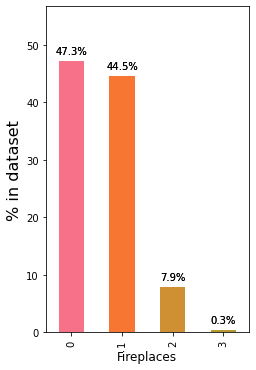

In [57]:
plt.figure(figsize=(8,6))
plotByPercentages(house_data, 'Fireplaces')
series = house_data.Fireplaces.value_counts(dropna = False)

print(series.sort_values())
print('\n')

4      5
0     81
3    181
1    369
2    824
Name: GarageCars, dtype: int64




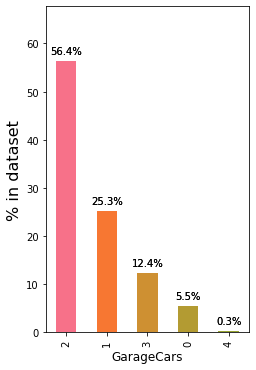

In [58]:
plt.figure(figsize=(8,6))
plotByPercentages(house_data, 'GarageCars')
series = house_data.GarageCars.value_counts(dropna = False)

print(series.sort_values())
print('\n')

1    696
0    764
Name: IsRemodelled, dtype: int64




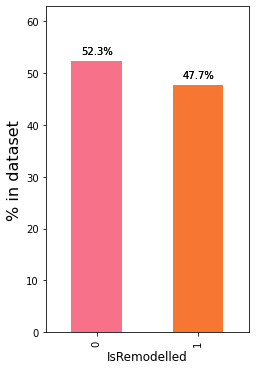

In [59]:
plt.figure(figsize=(8,6))
plotByPercentages(house_data, 'IsRemodelled')
series = house_data.IsRemodelled.value_counts(dropna = False)

print(series.sort_values())
print('\n')

#### Observations:
    Most preferred choices:
    - Month (House) Sold: June, followed by July and May
    - MSSubClass: Most preferred type of dwelling involved is 20 i.e. 1-Story 1946 & Newer All Styles, followed by 60 i.e. 2-Story 1946 & Newer.
    - Overall Quality (material and finish): Average and Above Average
    - Overall Condition: Mostly Average, followed by Above Average
        (i) Basement Full Bathrooms: Maximum 0(None), followed by 1.
        (ii) Full Bathrooms: Preferred 2, followed by 1 and
        (iii) Half Bathrooms: Preferred 0(None), followed by 1.
    - Bedrooms Above Ground:3, followed by 2.
    - Total Rooms Above Ground: 6, followed by 7.
    - No significant preferences for Fireplaces (0 0r 1) and IsRemodelled (House) or not.
    - GarageCars space: 2 car spaces, followed by 1 car space.

### Check for Duplicates

In [60]:
# Check if there are any duplicate values in the dataset

house_data[house_data.duplicated(keep=False)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage


No duplicate entries found.

### Outlier Treatment

In [61]:
# Checking outliers at 25%,50%,75%,90%,95% and above

house_data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,103.117123,443.639726,567.240411,1057.429452,1162.626712,346.992466,1515.463699,0.425342,1.565068,0.382877,2.866438,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,6.321918,180921.195890,0.476712,22.950000,0.275342
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,180.731373,456.098091,441.866955,438.705324,386.587738,436.528436,525.480383,0.518911,0.550916,0.502885,0.815778,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,2.703626,79442.502883,0.499629,20.640653,0.446840
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000,0.000000,-1.000000,0.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,1129.500000,0.000000,1.000000,0.000000,2.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,5.000000,129975.000000,0.000000,4.000000,0.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,1464.000000,0.000000,2.000000,0.000000,3.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,6.000000,163000.000000,0.000000,14.000000,0.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,808.000000,1298.250000,1391.250000,728.000000,1776.750000,1.000000,2.000000,1.000000,3.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,8.000000,214000.000000,1.000000,41.000000,1.000000
90%,1314.100000,120.000000,92.000000,14381.700000,8.000000,7.000000,335.000000,1065.500000,1232.000000,1602.200000,1680.000000,954.200000,2158.300000,1.000000,2.000000,1.000000,4.000000,9.000000,1.000000,3.000000,757.100000,262.000000,130.000000,10.000000,278000.000000,1.000000,56.000000,1.000000
95%,1387.050000,160.000000,104.000000,17401.150000,8.000000,8.000000,456.000000,1274.000000,1468.000000,1753.000000,1831.250000,1141.050000,2466.100000,1.000000,2.000000,1.000000,4.000000,10.000000,2.000000,3.000000,850.100000,335.000000,175.050000,11.000000,326100.000000,1.000000,58.000000,1.000000
99%,1445.410000,190.000000,137.410000,37567.640000,10.000000,9.000000,791.280000,1572.410000,1797.050000,2155.050000,2219.460000,1418.920000,3123.480000,2.000000,3.000000,1.000000,5.000000,11.000000,2.000000,3.000000,1002.790000,505.460000,285.820000,12.000000,442567.010000,1.000000,60.000000,1.000000


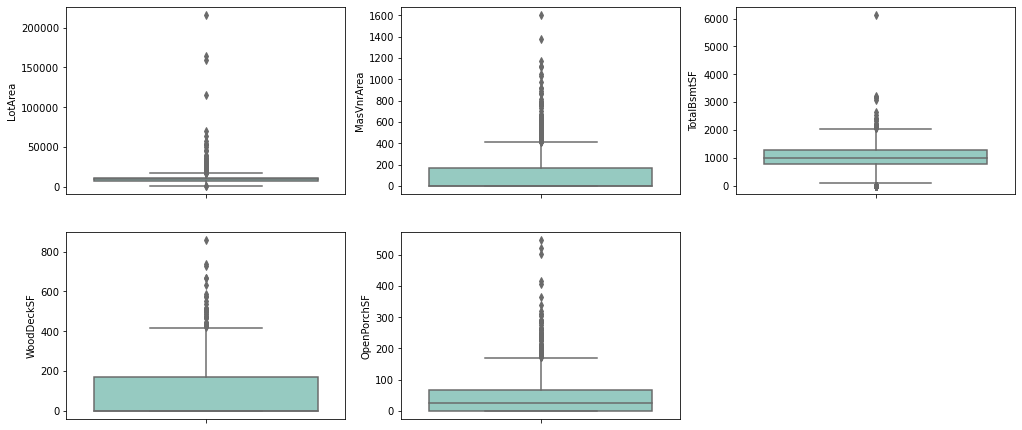

In [62]:
# Check the outliers in all the numeric columns

plt.figure(figsize=(17, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', palette='Set3', data = house_data)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', palette='Set3', data = house_data)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', palette='Set3', data = house_data)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', palette='Set3', data = house_data)
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', palette='Set3', data = house_data)
plt.show()

In [63]:
# Removing Outliers

# Removing values beyond 98% for LotArea

nn_quartile_LotArea = house_data['LotArea'].quantile(0.98)
house_data = house_data[house_data["LotArea"] < nn_quartile_LotArea]

# Removing values beyond 98% for MasVnrArea

nn_quartile_MasVnrArea = house_data['MasVnrArea'].quantile(0.98)
house_data = house_data[house_data["MasVnrArea"] < nn_quartile_MasVnrArea]

# Removing values beyond 99% for TotalBsmtSF

nn_quartile_TotalBsmtSF = house_data['TotalBsmtSF'].quantile(0.99)
house_data = house_data[house_data["TotalBsmtSF"] < nn_quartile_TotalBsmtSF]

# Removing values beyond 99% for WoodDeckSF

nn_quartile_WoodDeckSF = house_data['WoodDeckSF'].quantile(0.99)
house_data = house_data[house_data["WoodDeckSF"] < nn_quartile_WoodDeckSF]

# Removing values beyond 99% for OpenPorchSF

nn_quartile_OpenPorchSF = house_data['OpenPorchSF'].quantile(0.99)
house_data = house_data[house_data["OpenPorchSF"] < nn_quartile_OpenPorchSF]

In [64]:
# Determine the percentage of data retained

num_data = round(100*(len(house_data)/1460),2)
print(num_data)

93.01


## Step 3: Data Visualization

Visualising the Target Variable: SalePrice


 mu = 173371.72 and sigma = 67852.48



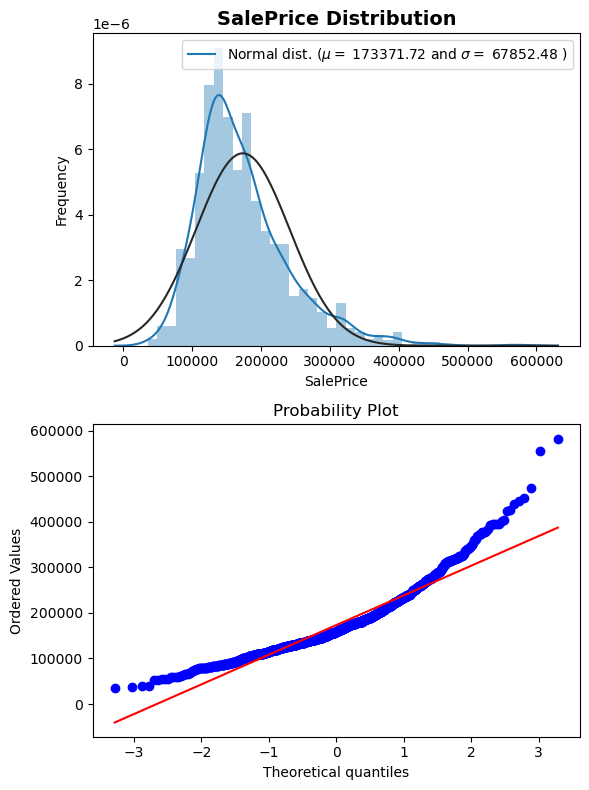

In [65]:
# Visualising the target variable 'SalePrice'
# from scipy import stats
# from scipy.stats import norm

plt.figure(figsize=(6,8), dpi=100)
plt.subplot(211)
sns.distplot(house_data['SalePrice'], fit=norm)

# Get the fitted parameters used by the function

(mu, sigma) = norm.fit(house_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plotting the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency', fontsize=10)
plt.title('SalePrice Distribution', fontsize=14, fontweight='bold')

# Get the QQ-plot
plt.subplot(212)
res = stats.probplot(house_data['SalePrice'], plot=plt)

plt.autoscale()
plt.tight_layout()
plt.show()

#### Observation: 

    The points on the probplot don't lie along the red line. It shows the skewness in the data of the target variable. Hence, transforming the variable using log-transform.


 mu = 11.99 and sigma = 0.37



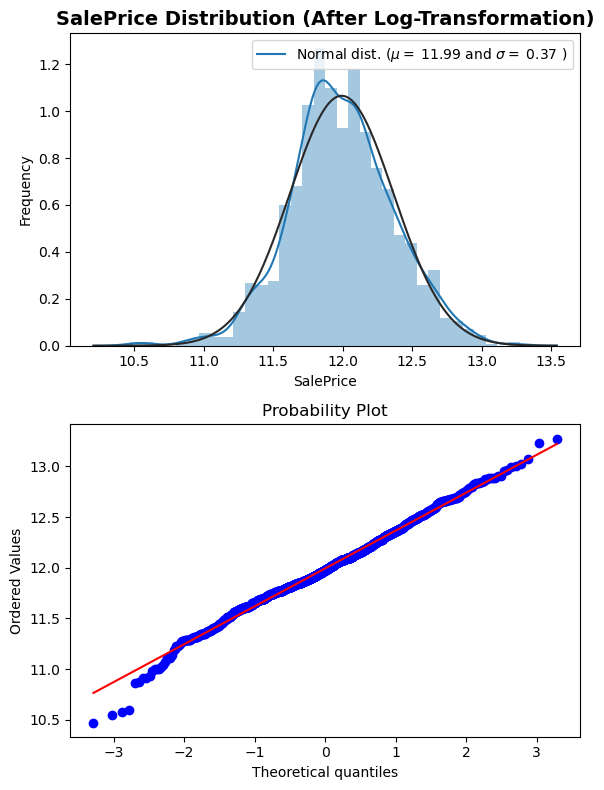

In [66]:
# Tranforming the target variable 'SalePrice' using Log-Transform. 

# from scipy import stats
# from scipy.stats import norm

# Using the numpy fuction log1p which that applies log(1+x) to all elements of the target variable column
house_data["SalePrice"] = np.log1p(house_data["SalePrice"])

plt.figure(figsize=(6,8), dpi=100)
plt.subplot(211)
sns.distplot(house_data['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(house_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plotting the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency', fontsize=10)
plt.title("SalePrice Distribution (After Log-Transformation)", fontsize=14, fontweight='bold')

# Get the QQ-plot
plt.subplot(212)
res = stats.probplot(house_data['SalePrice'], plot=plt)

plt.autoscale()
plt.tight_layout()
plt.show()

#### Observations:
    - The normal distribution plot now shows that the new distribution of SalePrice (log-transformed) is almost normally distributed.
    - The points on the probplot almost lie along the red line. It shows that the skewness issue in the data of the target variable, 'SalePrice' is almost resolved with some noise.

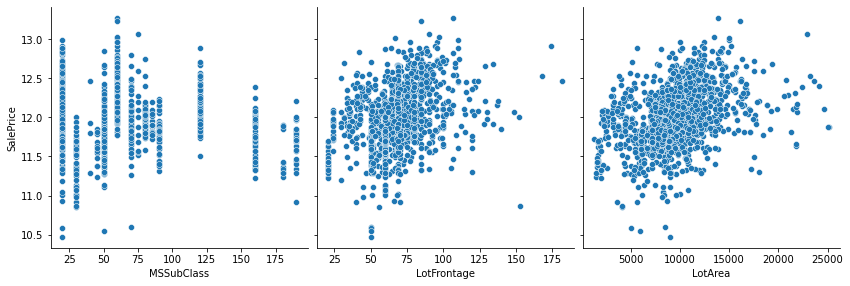

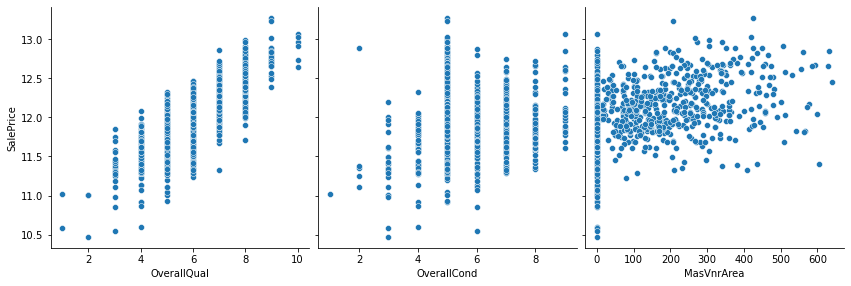

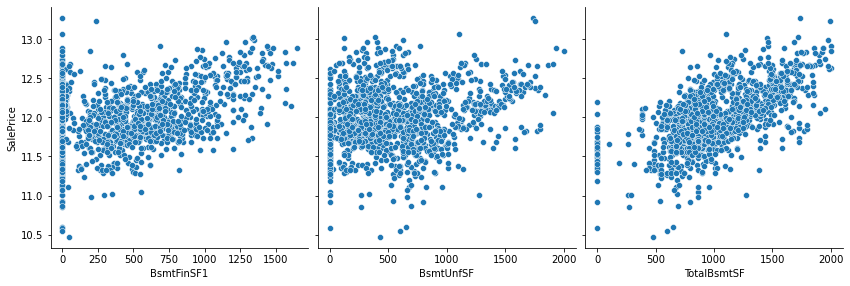

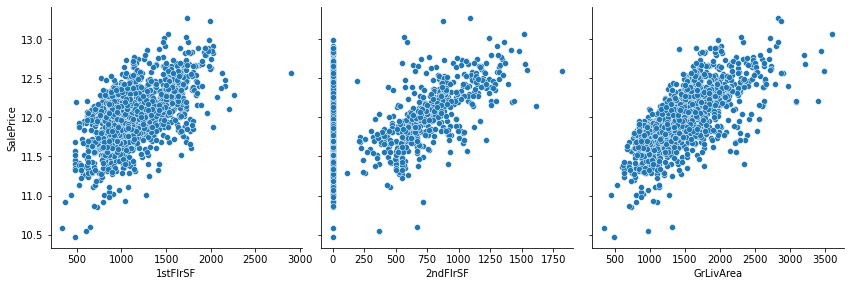

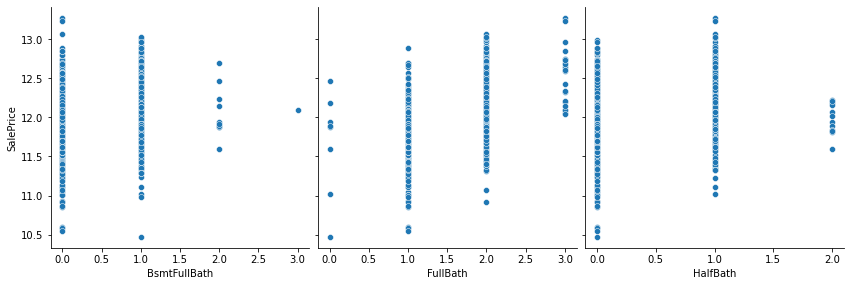

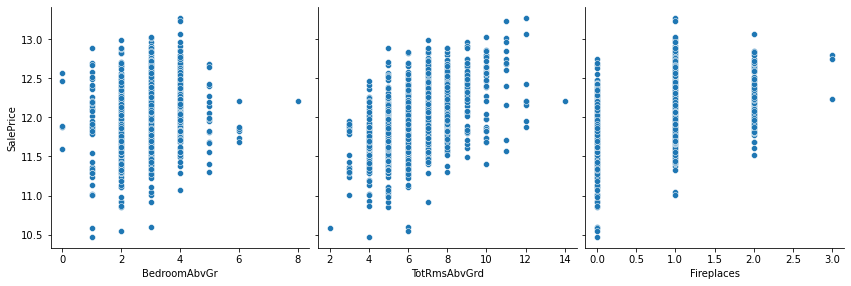

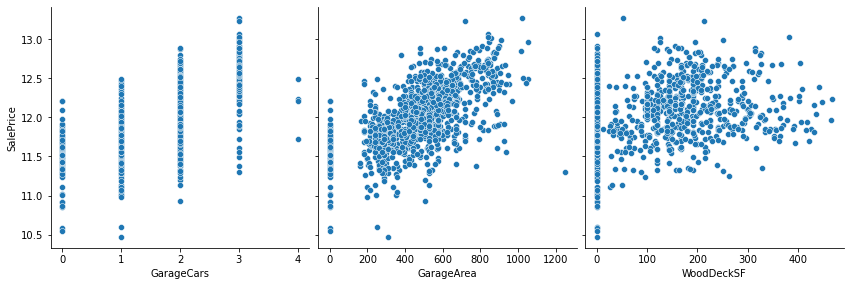

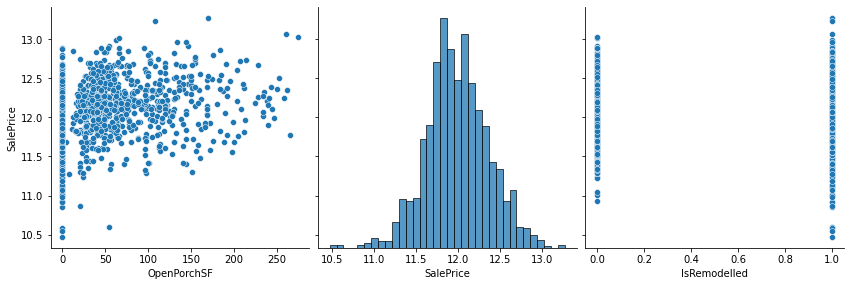

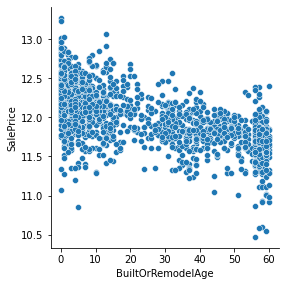

In [67]:
# Check the numerical values using pairplots

sns.pairplot(house_data, x_vars=['MSSubClass','LotFrontage','LotArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(house_data, x_vars=['OverallQual', 'OverallCond','MasVnrArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(house_data, x_vars=['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(house_data, x_vars=['1stFlrSF','2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(house_data, x_vars=['BsmtFullBath','FullBath', 'HalfBath'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(house_data, x_vars=['BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(house_data, x_vars=['GarageCars','GarageArea', 'WoodDeckSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(house_data, x_vars=['OpenPorchSF','SalePrice', 'IsRemodelled'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(house_data, x_vars=['BuiltOrRemodelAge'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()



### Observations : 
    

    - '1stFlrSF','GrLivArea' show a positive correlation with the SalePrice.
    - Other continuous variables are too scattered. Let's understand them from further analysis.

<Figure size 1440x1200 with 0 Axes>

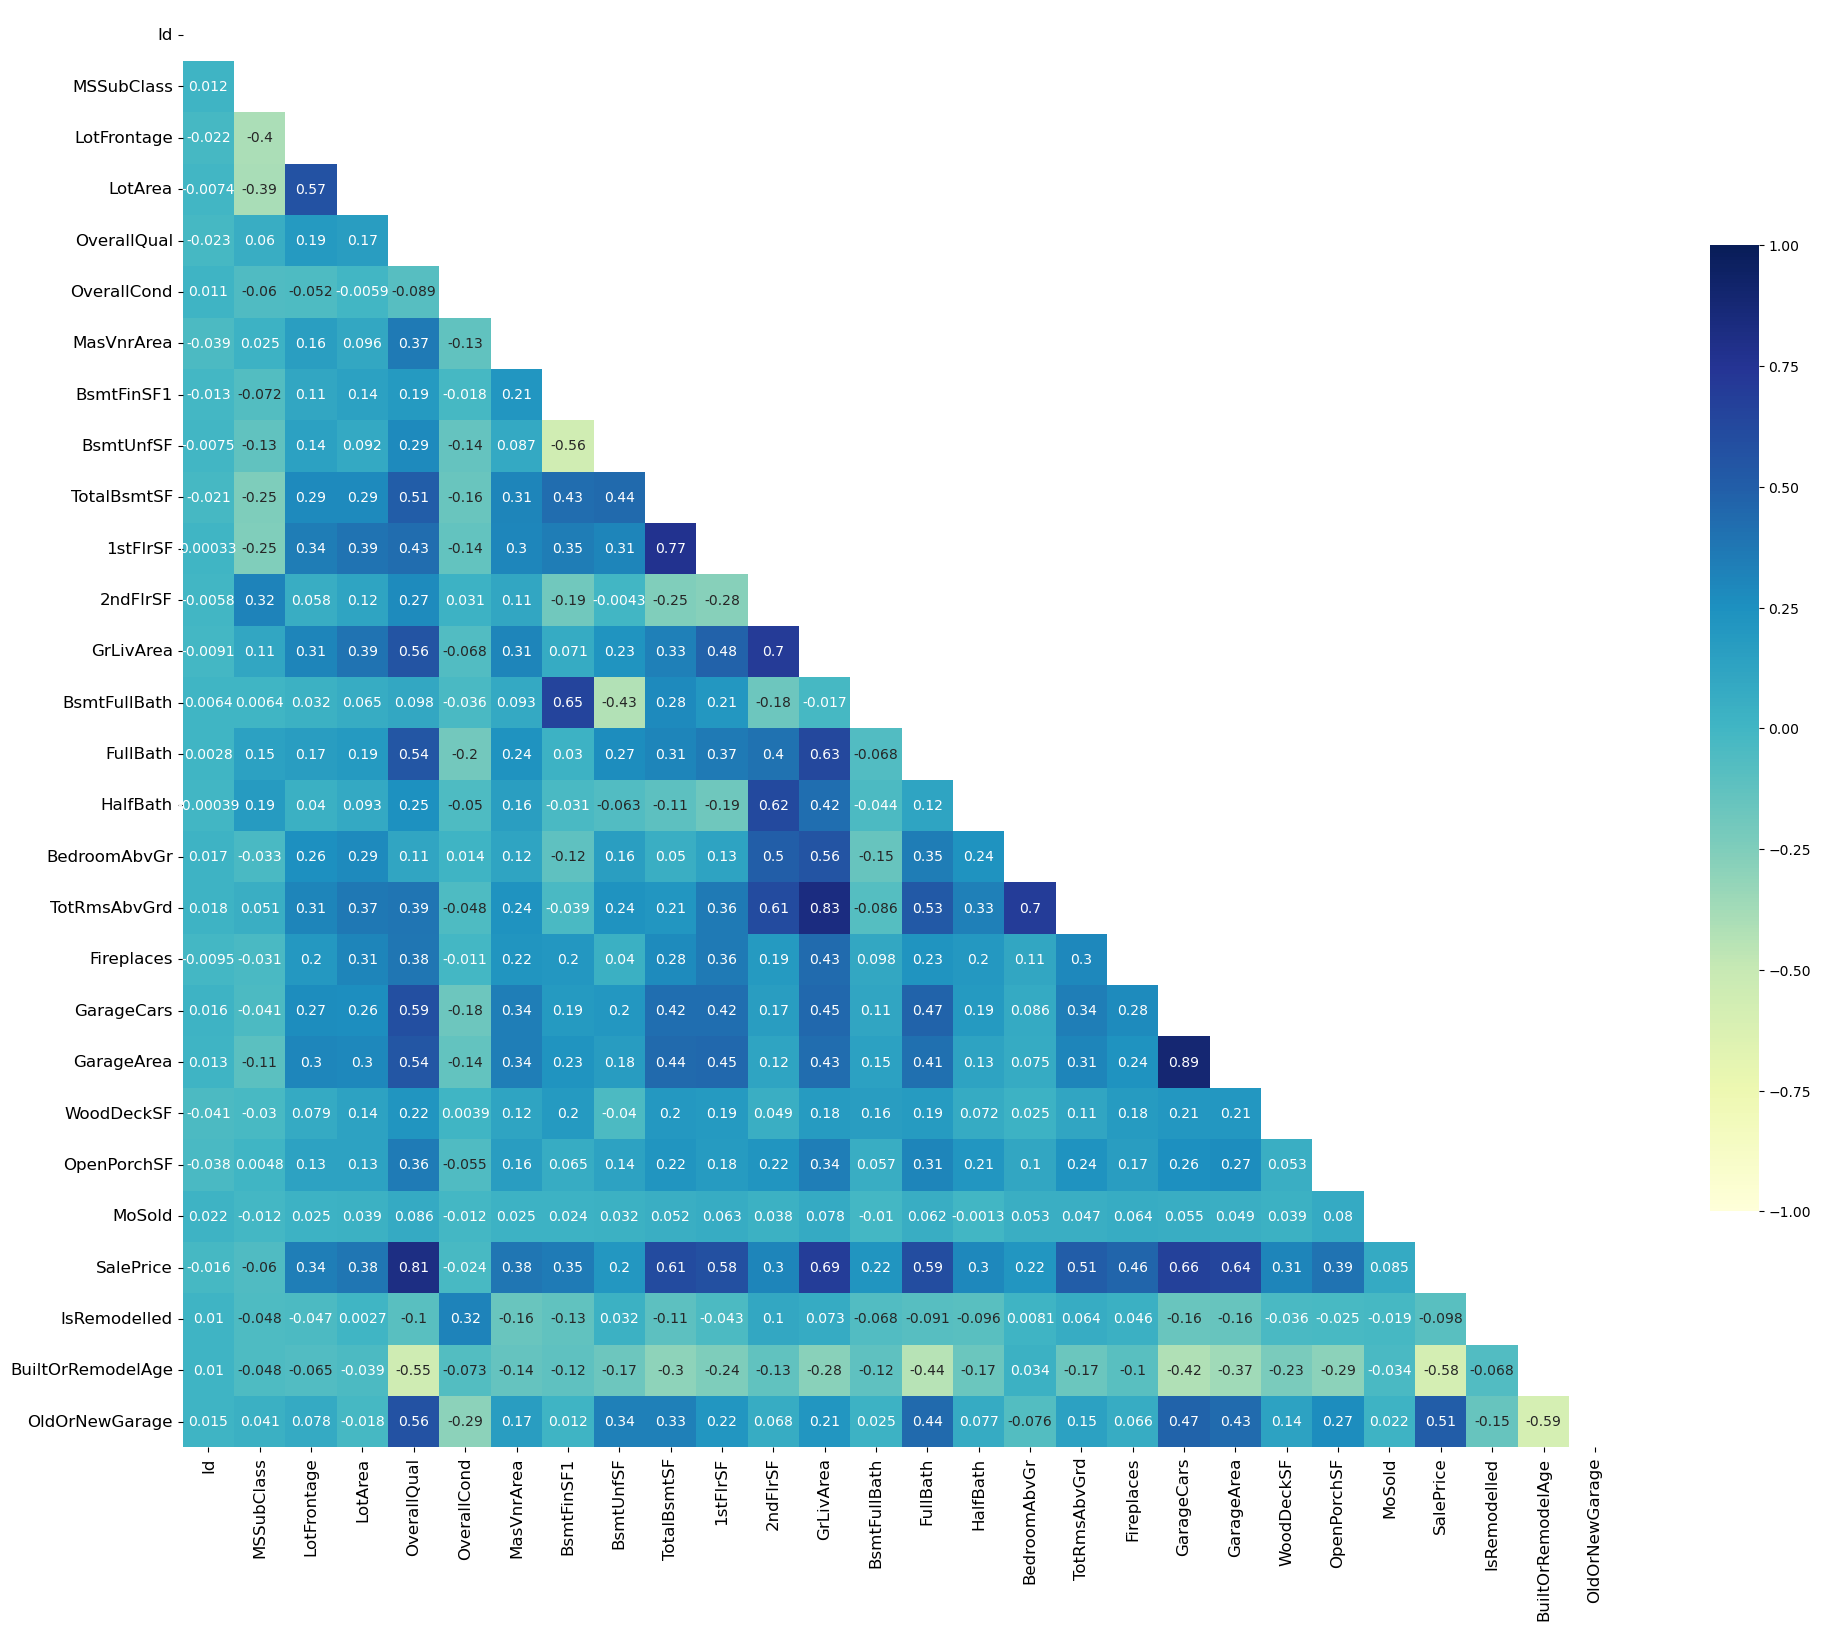

In [68]:
# Plotting a heatmap to understand correlation amongst numeric variables

plt.figure(figsize = (12,10), dpi=120)
corr_matrix = house_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
plt.subplots(figsize=(20, 20), dpi=100)
sns.heatmap(corr_matrix, cmap= 'YlGnBu', cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0, 
            square=True, mask=mask, annot=True)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.autoscale()
plt.show()

#### Observations:
    - The predictors 'GrLivArea' and 'TotRmsAbvGrd' shows (0.83) strong positive correlation.
    Hence, dropping 'TotRmsAbvGrd'.
    - The predictors 'GarageCars' and 'GarageArea' shows (0.89) strong positive correlation.
    Hence, dropping 'GarageCars'.
    - The predictors 'GrLivArea' and '2ndFlrSF' shows (0.70) strong positive correlation.
    Hence, dropping '2ndFlrSF'.
    - The predictors '1stFlrSF' and 'TotalBsmtSF' shows (0.77) strong positive correlation. 
    Hence, dropping '1stFlrSF'.

In [69]:
# Dropping the highly correlated predictors to reduce multicollinearity.

house_data = house_data.drop(['TotRmsAbvGrd', 'GarageCars', '2ndFlrSF', '1stFlrSF'], axis = 1)
house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,1710,1,2,1,3,Gd,0,None,Attchd,RFn,548,0,61,2,12.247699,0,5,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,2,0,3,TA,1,TA,Attchd,RFn,460,298,0,5,12.109016,0,31,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,1786,1,2,1,3,Gd,1,TA,Attchd,RFn,608,0,42,9,12.317171,1,6,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,1717,1,1,0,3,Gd,1,Gd,Detchd,Unf,642,0,35,2,11.849405,1,36,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,2198,1,2,1,4,Gd,1,TA,Attchd,RFn,836,192,84,12,12.429220,0,8,1


In [70]:
# Check the shape of the dataframe

house_data.shape

(1358, 43)

## Step 4: Data Preparation
    
- Converting categorical data into numercal data
- Creating Dummies

In [71]:
# Since the values of the following fields are ordered list, we shall assign values to them in sequence
# For values which can be ordered, we have given an ordered sequence value
# For values which cannot be ordered, we have categorised them into 0 and 1

house_data['d_LotShape'] = house_data['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
house_data['d_ExterQual'] = house_data['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })

house_data['d_BsmtQual'] = house_data['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
house_data['d_BsmtExposure'] = house_data['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
house_data['d_BsmtFinType1'] = house_data['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 
                                                                 'None': 0})
house_data['d_HeatingQC'] = house_data['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
house_data['d_KitchenQual'] = house_data['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
house_data['d_FireplaceQu'] = house_data['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
house_data['d_GarageFinish'] = house_data['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })

house_data['d_HouseStyle'] = house_data['HouseStyle'].map({'SLvl': 8, 'SFoyer': 7, '2.5Fin': 6, '2.5Unf': 5, '2Story': 4, 
                                                                 '1.5Fin': 3, '1.5Unf': 2, '1Story': 1, 'None': 0 })
house_data['d_LotConfig'] = house_data['LotConfig'].map({'Inside': 5, 'Corner': 4, 'CulDSac': 3, 'FR2': 2, 'FR3': 1, 
                                                           'None': 0  })
house_data['d_MasVnrType'] = house_data['MasVnrType'].map({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0 })

house_data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_HouseStyle,d_LotConfig,d_MasVnrType
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,1710,1,2,1,3,Gd,0,None,Attchd,RFn,548,0,61,2,12.247699,0,5,1,3,4,4,1,6,5,4,0,2,4,5,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,2,0,3,TA,1,TA,Attchd,RFn,460,298,0,5,12.109016,0,31,0,3,3,4,4,5,5,3,3,2,1,2,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,1786,1,2,1,3,Gd,1,TA,Attchd,RFn,608,0,42,9,12.317171,1,6,1,2,4,4,2,6,5,4,3,2,4,5,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,1717,1,1,0,3,Gd,1,Gd,Detchd,Unf,642,0,35,2,11.849405,1,36,0,2,3,3,1,5,4,4,4,1,4,4,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,2198,1,2,1,4,Gd,1,TA,Attchd,RFn,836,192,84,12,12.429220,0,8,1,2,4,4,3,6,5,4,3,2,4,2,1


In [72]:
# drop the old columns from which the new columns were derived

house_data = house_data.drop(['LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 
                                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'HouseStyle', 
                                'LotConfig', 'MasVnrType'], axis=1)

# Removing 'Id' and 'MoSold' columns as they are trivial for our analysis
house_data = house_data.drop(['Id','MoSold'], axis=1)

house_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,Foundation,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageType,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_HouseStyle,d_LotConfig,d_MasVnrType
0,60,RL,65.0,8450,CollgCr,7,5,Gable,VinylSd,VinylSd,196.0,PConc,706,150,856,1710,1,2,1,3,0,Attchd,548,0,61,12.247699,0,5,1,3,4,4,1,6,5,4,0,2,4,5,1
1,20,RL,80.0,9600,Veenker,6,8,Gable,MetalSd,MetalSd,0.0,CBlock,978,284,1262,1262,0,2,0,3,1,Attchd,460,298,0,12.109016,0,31,0,3,3,4,4,5,5,3,3,2,1,2,0
2,60,RL,68.0,11250,CollgCr,7,5,Gable,VinylSd,VinylSd,162.0,PConc,486,434,920,1786,1,2,1,3,1,Attchd,608,0,42,12.317171,1,6,1,2,4,4,2,6,5,4,3,2,4,5,1
3,70,RL,60.0,9550,Crawfor,7,5,Gable,Wd Sdng,Wd Shng,0.0,BrkTil,216,540,756,1717,1,1,0,3,1,Detchd,642,0,35,11.849405,1,36,0,2,3,3,1,5,4,4,4,1,4,4,0
4,60,RL,84.0,14260,NoRidge,8,5,Gable,VinylSd,VinylSd,350.0,PConc,655,490,1145,2198,1,2,1,4,1,Attchd,836,192,84,12.429220,0,8,1,2,4,4,3,6,5,4,3,2,4,2,1


In [73]:
house_data.shape

(1358, 41)

In [74]:
# For the following columns create dummies

# Creating dummies for MSZoning

d_MSZoning = pd.get_dummies(house_data['MSZoning'], prefix='MSZoning', drop_first = True)
house_data = pd.concat([house_data, d_MSZoning], axis = 1)

# Creating dummies for Neighborhood

d_Neighborhood = pd.get_dummies(house_data['Neighborhood'], prefix='Neighborhood', drop_first = True)
house_data = pd.concat([house_data, d_Neighborhood], axis = 1)

# Creating dummies for RoofStyle

d_RoofStyle = pd.get_dummies(house_data['RoofStyle'], prefix='RoofStyle', drop_first = True)
house_data = pd.concat([house_data, d_RoofStyle], axis = 1)

# Creating dummies for Exterior1st

d_Exterior1st = pd.get_dummies(house_data['Exterior1st'], prefix='Exterior1st', drop_first = True)
house_data = pd.concat([house_data, d_Exterior1st], axis = 1)

# Creating dummies for Exterior2nd

d_Exterior2nd = pd.get_dummies(house_data['Exterior2nd'], prefix='Exterior2nd', drop_first = True)
house_data = pd.concat([house_data, d_Exterior2nd], axis = 1)

# Creating dummies for Foundation

d_Foundation = pd.get_dummies(house_data['Foundation'], prefix='Foundation', drop_first = True)
house_data = pd.concat([house_data, d_Foundation], axis = 1)

# Creating dummies for GarageType

d_GarageType = pd.get_dummies(house_data['GarageType'], prefix='GarageType', drop_first = True)
house_data = pd.concat([house_data, d_GarageType], axis = 1)

house_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,Foundation,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageType,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_HouseStyle,d_LotConfig,d_MasVnrType,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,RL,65.0,8450,CollgCr,7,5,Gable,VinylSd,VinylSd,196.0,PConc,706,150,856,1710,1,2,1,3,0,Attchd,548,0,61,12.247699,0,5,1,3,4,4,1,6,5,4,0,2,4,5,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,20,RL,80.0,9600,Veenker,6,8,Gable,MetalSd,MetalSd,0.0,CBlock,978,284,1262,1262,0,2,0,3,1,Attchd,460,298,0,12.109016,0,31,0,3,3,4,4,5,5,3,3,2,1,2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,60,RL,68.0,11250,CollgCr,7,5,Gable,VinylSd,VinylSd,162.0,PConc,486,434,920,1786,1,2,1,3,1,Attchd,608,0,42,12.317171,1,6,1,2,4,4,2,6,5,4,3,2,4,5,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,70,RL,60.0,9550,Crawfor,7,5,Gable,Wd Sdng,Wd Shng,0.0,BrkTil,216,540,756,1717,1,1,0,3,1,Detchd,642,0,35,11.849405,1,36,0,2,3,3,1,5,4,4,4,1,4,4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,60,RL,84.0,14260,NoRidge,8,5,Gable,VinylSd,VinylSd,350.0,PConc,655,490,1145,2198,1,2,1,4,1,Attchd,836,192,84,12.429220,0,8,1,2,4,4,3,6,5,4,3,2,4,2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


In [75]:
# drop the below columns as we now have new columns derived from these columns

house_data = house_data.drop(['MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 
                                'GarageType'], axis=1)

house_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_HouseStyle,d_LotConfig,d_MasVnrType,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,65.0,8450,7,5,196.0,706,150,856,1710,1,2,1,3,0,548,0,61,12.247699,0,5,1,3,4,4,1,6,5,4,0,2,4,5,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,20,80.0,9600,6,8,0.0,978,284,1262,1262,0,2,0,3,1,460,298,0,12.109016,0,31,0,3,3,4,4,5,5,3,3,2,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,60,68.0,11250,7,5,162.0,486,434,920,1786,1,2,1,3,1,608,0,42,12.317171,1,6,1,2,4,4,2,6,5,4,3,2,4,5,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,70,60.0,9550,7,5,0.0,216,540,756,1717,1,1,0,3,1,642,0,35,11.849405,1,36,0,2,3,3,1,5,4,4,4,1,4,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,60,84.0,14260,8,5,350.0,655,490,1145,2198,1,2,1,4,1,836,192,84,12.429220,0,8,1,2,4,4,3,6,5,4,3,2,4,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


In [76]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1458
Columns: 107 entries, MSSubClass to GarageType_None
dtypes: float64(3), int64(31), uint8(73)
memory usage: 468.1 KB


In [77]:
house_data.shape

(1358, 107)

In [78]:
##Creating a copy of this dataframe for 'Question 3'

house_data_copy = house_data.copy()

Now all columns in dataset are numeric.


## Step 5: Train Test Split

In [79]:
# Putting all feature variable to X

X = house_data.drop(['SalePrice'], axis=1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_HouseStyle,d_LotConfig,d_MasVnrType,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,65.0,8450,7,5,196.0,706,150,856,1710,1,2,1,3,0,548,0,61,0,5,1,3,4,4,1,6,5,4,0,2,4,5,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,20,80.0,9600,6,8,0.0,978,284,1262,1262,0,2,0,3,1,460,298,0,0,31,0,3,3,4,4,5,5,3,3,2,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,60,68.0,11250,7,5,162.0,486,434,920,1786,1,2,1,3,1,608,0,42,1,6,1,2,4,4,2,6,5,4,3,2,4,5,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,70,60.0,9550,7,5,0.0,216,540,756,1717,1,1,0,3,1,642,0,35,1,36,0,2,3,3,1,5,4,4,4,1,4,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,60,84.0,14260,8,5,350.0,655,490,1145,2198,1,2,1,4,1,836,192,84,0,8,1,2,4,4,3,6,5,4,3,2,4,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


In [80]:
# Putting response variable to y

y = house_data['SalePrice']
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

### Scaling the features

In [81]:
# Use StandardScaler

scaler = StandardScaler()
col = X.columns
X[col] = scaler.fit_transform(X[col])

In [82]:
# Split Train data in 70% and Test data in 30%

# from sklearn.model_selection import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

print("Train dataset shape", X_train.shape)

print("Test  dataset shape", X_test.shape)

Train dataset shape (950, 106)
Test  dataset shape (408, 106)


## Step 6: Recursive feature elimination (RFE)

    Since there are around 107 features, we will use RFE to get the best 50 features out of the 107 features and
    use the new features for further analysis

In [83]:
# Running RFE with the output number of the variable equal to 50

lm = LinearRegression()
lm.fit(X_train, y_train)

# Running RFE
rfe = RFE(lm, n_features_to_select=50)    
rfe = rfe.fit(X_train, y_train)

In [84]:
# Assign the columns selected by RFE to cols

col = X_train.columns[rfe.support_]

# Assign the 50 features selected using RFE to a dataframe and view them

temp_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), 
                       columns=['Variable', 'rfe_support', 'rfe_ranking'])
temp_df = temp_df.loc[temp_df['rfe_support'] == True]
temp_df.reset_index(drop=True, inplace=True)

temp_df

,Variable,rfe_support,rfe_ranking
0,MSSubClass,True,1
1,LotArea,True,1
2,OverallQual,True,1
3,OverallCond,True,1
4,BsmtFinSF1,True,1
5,TotalBsmtSF,True,1
6,GrLivArea,True,1
7,BsmtFullBath,True,1
8,FullBath,True,1
9,HalfBath,True,1


In [85]:
# Assign the 50 columns to X_train_rfe

X_train_rfe = X_train[col]

In [86]:
# Associate the new 50 columns to X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

## Step 7: Model Building and Evaluation

### Ridge Regression

In [87]:
# list of alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                    6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [88]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])



,param_alpha,mean_train_score,mean_test_score,rank_test_score
14,3.0,-0.078475,-0.085361,1
13,2.0,-0.078426,-0.085362,2
15,4.0,-0.078527,-0.085371,3
16,5.0,-0.078584,-0.085379,4
12,1.0,-0.078375,-0.085382,5
17,6.0,-0.078637,-0.085384,6
11,0.9,-0.078370,-0.085384,7
10,0.8,-0.078366,-0.085387,8
18,7.0,-0.078687,-0.085388,9
9,0.7,-0.078363,-0.085389,10


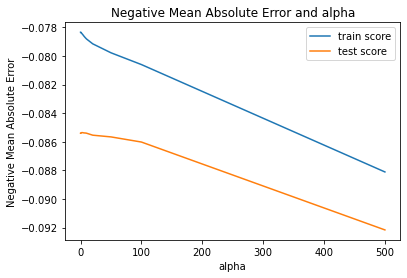

In [89]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [90]:
# get the best estimator for lambda

ridge_alpha = ridge_model_cv.best_params_.get("alpha")
ridge_alpha

3.0

In [91]:
# check the coefficient values with lambda = 3

ridge = Ridge(alpha=ridge_alpha)

ridge.fit(X_train, y_train)

print("Intercept: ", ridge.intercept_)
print("Coefficients:\n",ridge.coef_)

Intercept:  11.9955548598945
Coefficients:
 [-0.01826986  0.02442684  0.0660134   0.04677461  0.02581262  0.04711394
  0.10076751  0.00918653  0.01237762  0.02048561  0.02349987  0.03732977
  0.00956827 -0.00897897 -0.01885929  0.01528937  0.01172859  0.01654298
  0.00863071  0.02038533  0.01252426  0.01625863  0.00798248  0.06576946
  0.02606051  0.10621065  0.07897993  0.02527397 -0.0113355  -0.00857021
 -0.012204    0.02270236 -0.01587817 -0.01206467  0.01863022 -0.0101833
  0.00548748 -0.00207892 -0.03104741 -0.04062535 -0.02840223 -0.00207892
  0.03303882 -0.00315356  0.03497461  0.0213992   0.01854052  0.04696472
  0.01799807 -0.00982787]


In [92]:
##Making predictions for train and test sets: Ridge Regression Model
y_pred_train_r = ridge.predict(X_train)
y_pred_test_r = ridge.predict(X_test)

##R2 score for Ridge Regression Model
r2_score_ridge_train = r2_score(y_true= y_train, y_pred= y_pred_train_r)
r2_score_ridge_test = r2_score(y_true= y_test, y_pred= y_pred_test_r)

##Check the mean squared error (MSE) for Ridge Regression Model
MSE_ridge_train = mean_squared_error(y_train, y_pred_train_r)
MSE_ridge_test = mean_squared_error(y_test, y_pred_test_r)

##Mean Absolute error for train and test sets
MAE_ridge_train = mean_absolute_error(y_train, y_pred_train_r)
MAE_ridge_test = mean_absolute_error(y_test, y_pred_test_r)

##Root Mean Squared Error for Train and Test Sets
RMSE_ridge_train = np.sqrt(MSE_ridge_train)
RMSE_ridge_test = np.sqrt(MSE_ridge_test)


print("For Ridge Regression Model\n(Original Model, alpha=3.0):\n","-"*40)
print("\nFor Train Set:\nR2 score:",r2_score_ridge_train,"\nMSE score:",MSE_ridge_train,"\nMAE score:",MAE_ridge_train,\
     "\nRMSE score:",RMSE_ridge_train)
print("\nFor Test Set:\nR2 score:",r2_score_ridge_test,"\nMSE score:",MSE_ridge_test,"\nMAE score:",MAE_ridge_test,\
      "\nRMSE score:",RMSE_ridge_test,"\n","-"*40)

For Ridge Regression Model
(Original Model, alpha=3.0):
 ----------------------------------------

For Train Set:
R2 score: 0.9180922801233271 
MSE score: 0.011524046417113963 
MAE score: 0.07909235706433 
RMSE score: 0.10735011139777156

For Test Set:
R2 score: 0.9000270308416499 
MSE score: 0.01390852662943933 
MAE score: 0.080325529172808 
RMSE score: 0.11793441664518178 
 ----------------------------------------


In [93]:
# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

,Features,Coefficient
0,MSSubClass,-0.0183
1,LotArea,0.0244
2,OverallQual,0.0660
3,OverallCond,0.0468
4,BsmtFinSF1,0.0258
5,TotalBsmtSF,0.0471
6,GrLivArea,0.1008
7,BsmtFullBath,0.0092
8,FullBath,0.0124
9,HalfBath,0.0205


In [94]:
# Assign the Features and their coefficient values to a dictionary which would be used while plotting the bar plot

ridge_coeff_dict = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))
ridge_coeff_dict

{'MSSubClass': -0.0183,
 'LotArea': 0.0244,
 'OverallQual': 0.066,
 'OverallCond': 0.0468,
 'BsmtFinSF1': 0.0258,
 'TotalBsmtSF': 0.0471,
 'GrLivArea': 0.1008,
 'BsmtFullBath': 0.0092,
 'FullBath': 0.0124,
 'HalfBath': 0.0205,
 'Fireplaces': 0.0235,
 'GarageArea': 0.0373,
 'WoodDeckSF': 0.0096,
 'IsRemodelled': -0.009,
 'BuiltOrRemodelAge': -0.0189,
 'OldOrNewGarage': 0.0153,
 'd_BsmtQual': 0.0117,
 'd_BsmtExposure': 0.0165,
 'd_BsmtFinType1': 0.0086,
 'd_HeatingQC': 0.0204,
 'd_KitchenQual': 0.0125,
 'd_GarageFinish': 0.0163,
 'd_HouseStyle': 0.008,
 'MSZoning_FV': 0.0658,
 'MSZoning_RH': 0.0261,
 'MSZoning_RL': 0.1062,
 'MSZoning_RM': 0.079,
 'Neighborhood_Crawfor': 0.0253,
 'Neighborhood_Edwards': -0.0113,
 'Neighborhood_IDOTRR': -0.0086,
 'Neighborhood_MeadowV': -0.0122,
 'Neighborhood_NridgHt': 0.0227,
 'Neighborhood_OldTown': -0.0159,
 'Neighborhood_SWISU': -0.0121,
 'Neighborhood_StoneBr': 0.0186,
 'Exterior1st_BrkComm': -0.0102,
 'Exterior1st_BrkFace': 0.0055,
 'Exterior1st_CBl

In [95]:
# Do an RFE to minimise the features to 15
X_train_ridge = X_train[ridge_df.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

# running RFE
rfe = RFE(lm, n_features_to_select=15)            
rfe = rfe.fit(X_train_ridge, y_train)

In [96]:
# Method to get the coefficient values

def find(x):
    return ridge_coeff_dict[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

top10_ridge_df = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
top10_ridge_df = top10_ridge_df.loc[top10_ridge_df['rfe_support'] == True]
top10_ridge_df.reset_index(drop=True, inplace=True)

top10_ridge_df['Coefficient'] = top10_ridge_df['Features'].apply(find)
top10_ridge_df = top10_ridge_df.sort_values(by=['Coefficient'], ascending=False)
top10_ridge_df = top10_ridge_df.head(10)
top10_ridge_df

,Features,rfe_support,rfe_ranking,Coefficient
10,MSZoning_RL,True,1,0.1062
4,GrLivArea,True,1,0.1008
11,MSZoning_RM,True,1,0.0790
0,OverallQual,True,1,0.0660
8,MSZoning_FV,True,1,0.0658
3,TotalBsmtSF,True,1,0.0471
14,Foundation_PConc,True,1,0.0470
1,OverallCond,True,1,0.0468
6,GarageArea,True,1,0.0373
13,Exterior2nd_CmentBd,True,1,0.0330


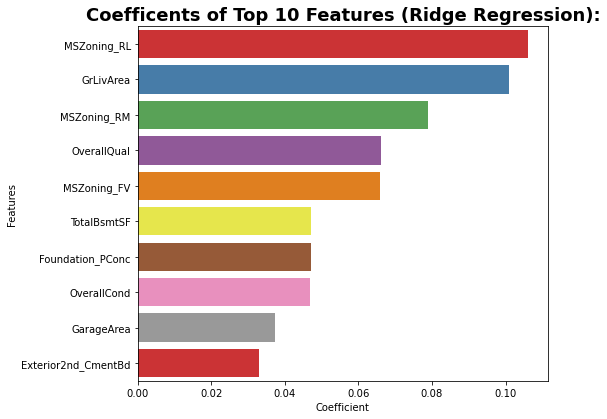

In [97]:
# bar plot to determine the top 10 variables that would affect pricing most using ridge regression

plt.figure(figsize=(25,30))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = top10_ridge_df)
plt.title('Coefficents of Top 10 Features (Ridge Regression):', fontsize=18,fontweight='bold')

plt.show()

    The chart mentioned above displays the Top 10 predictors based on the Ridge Regression model, that are significant in predicting the sale price of the house.

### Residual Analysis of Model

    Checking for the error terms distribution. They should be normally distributed (as it is one of the major assumptions of linear regression).


#### For Train Set:

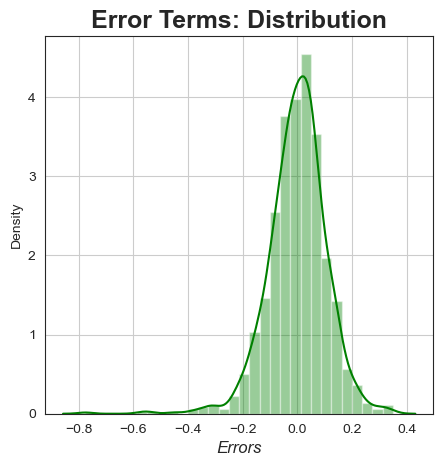

In [98]:
# Plot the histogram of the error terms
sns.set_style('white')
plt.figure(figsize=(5,5), dpi=100)
res = (y_train - y_pred_train_r)     #residuals
sns.distplot(res , bins = 30, color='g')
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
plt.grid(True)
plt.show()

#### Observation:

    Error terms seem to be approximately normally distributed with mean 0, so our assumption holds true.

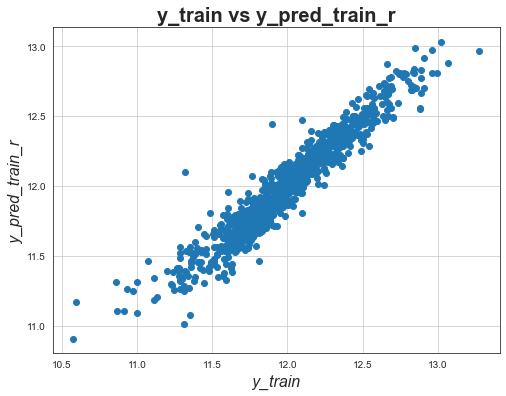

In [99]:
# Plotting y_train and y_train_pred to understand the spread.
sns.set_style('white')
plt.figure(figsize = (8,6))
plt.scatter(y_train,y_pred_train_r)
# plt.plot(y_test,y_pred_test_r, color = 'red' , linewidth = 3)
plt.title('y_train vs y_pred_train_r', fontweight='bold', fontsize = 20)           
plt.xlabel('y_train', fontstyle='italic', fontsize = 16)              
plt.ylabel('y_pred_train_r', fontstyle='italic', fontsize = 16) 
plt.grid(True)
plt.show()

In [100]:
y_train.shape

(950,)

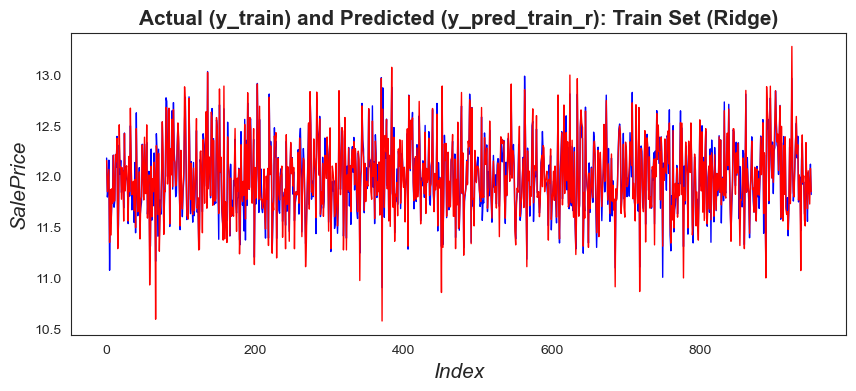

In [101]:
# Actual and Predicted (Train Set)
sns.set_style('white')
plt.figure(figsize = (10,4), dpi=100)
#Since y_train has 950 observations
pred_count = [i for i in range(0,950,1)] 
actual_count = [i for i in range(0,950,1)]

# Predicted 'y_pred_train_r' plot
plt.plot(pred_count, y_pred_train_r, color="blue", linewidth=1, linestyle="-")
# Actual 'y_train' plot
plt.plot(actual_count, y_train, color="red",  linewidth=1, linestyle="-")

plt.title("Actual (y_train) and Predicted (y_pred_train_r): Train Set (Ridge)", fontsize=15, fontweight='bold')    
plt.xlabel('Index', fontsize=15, fontstyle='italic')                              
plt.ylabel('SalePrice', fontsize=15, fontstyle='italic')  
plt.show()

- <span style="color:red;font-size:30">Red: Actual (y_train)</span>
- <span style="color:blue;font-size:30">Blue: Predicted (y_pred_train_r)</span>



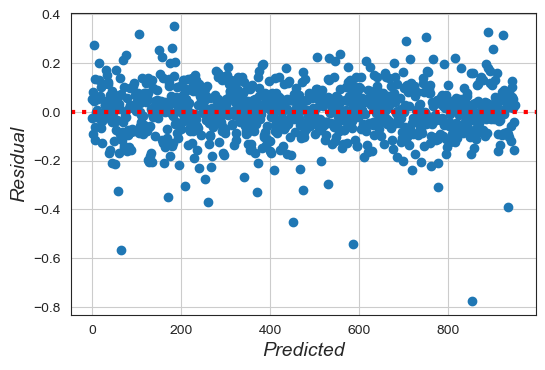

In [102]:
# Error terms for train set
sns.set_style('white')
plt.figure(figsize = (6,4), dpi=100)

# For 950 observations in the train set
train_count = [i for i in range(0,950,1)]

# Residuals (train set)
res_train = (y_train-y_pred_train_r) 
plt.scatter(train_count, res_train)
plt.axhline(y=0, color='r', linestyle=':', linewidth = 3)

plt.xlabel('Predicted', fontstyle='italic', fontsize=14)                      
plt.ylabel('Residual', fontstyle='italic', fontsize=14)   
plt.grid(True)
plt.show()

#### Observation:
    The residuals are scattered along (y=0) and are independent of each other.

#### For Test Set:

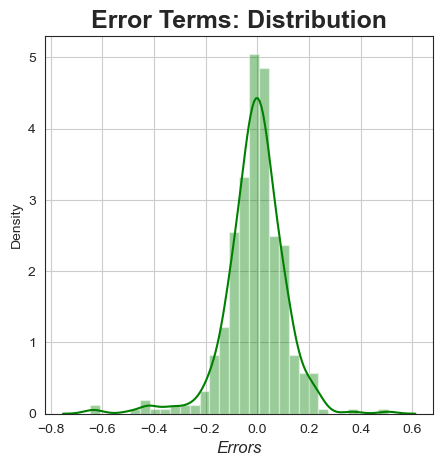

In [103]:
# Plot the histogram of the error terms (test set)

sns.set_style('white')
plt.figure(figsize=(5,5), dpi=100)
# Residuals
res = (y_test - y_pred_test_r)     
sns.distplot(res , bins = 30, color='g')
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
plt.grid(True)
plt.show()

#### Observation:

    Error terms seem to be approximately normally distributed with mean 0, so our assumption holds true.

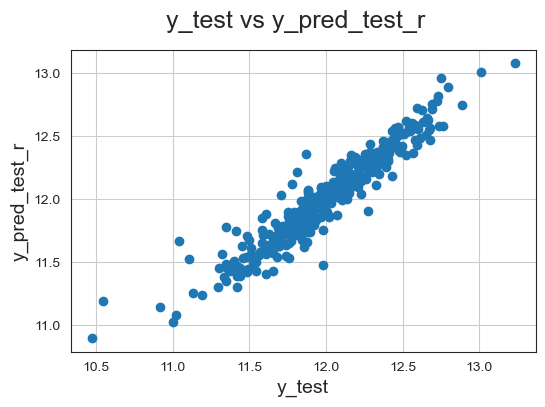

In [104]:
# Plotting y_test and y_pred_test_r to understand the spread.
sns.set_style('white')
fig = plt.figure(figsize=(6,4), dpi=100)
plt.scatter(y_test,y_pred_test_r)
fig.suptitle('y_test vs y_pred_test_r', fontsize=18)             
plt.xlabel('y_test', fontsize=14)                       
plt.ylabel('y_pred_test_r', fontsize=14)  
plt.grid(True)
plt.show()

In [105]:
y_test.shape

(408,)

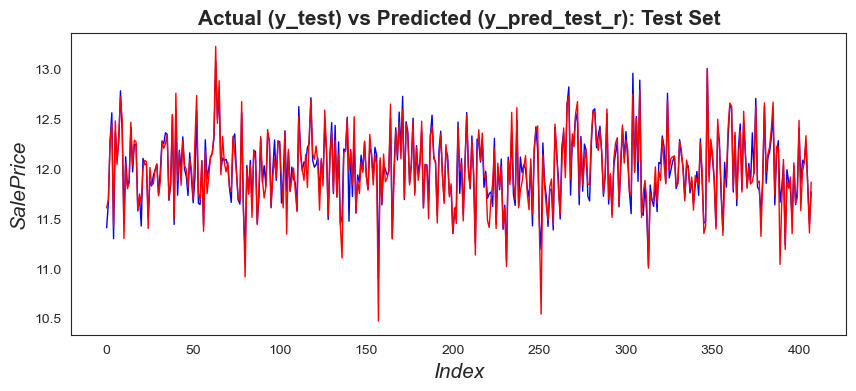

In [106]:
# Actual vs Predicted (Test Set)
plt.figure(figsize = (10,4), dpi=100)

# Test set has 408 observations
pred_test_count = [i for i in range(0,408,1)]
actual_test_count = [i for i in range(0,408,1)]

# Predicted 'y_pred_test_r' plot(test pred)
plt.plot(pred_test_count, y_pred_test_r, color="blue", linewidth=1, linestyle="-")

# Actual 'y_test' plot
plt.plot(actual_test_count, y_test, color="red",  linewidth=1, linestyle="-")
plt.title('Actual (y_test) vs Predicted (y_pred_test_r): Test Set', fontsize=15, fontweight='bold')                              
plt.ylabel('SalePrice', fontsize=15, fontstyle='italic')  
plt.xlabel('Index', fontsize=15, fontstyle='italic')
plt.show()


- <span style="color:red">Red: Actual (y_test)</span>
- <span style="color:blue">Blue: Predicted (y_pred_test_r)</span>

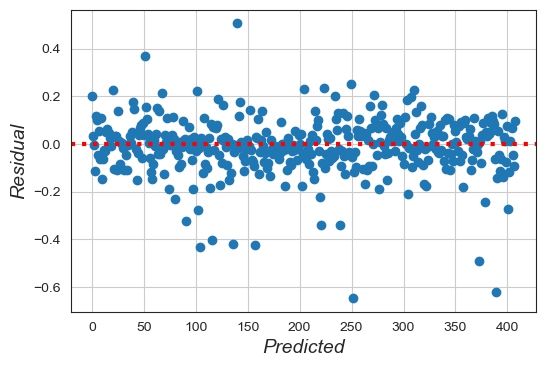

In [107]:
# Error terms

fig = plt.figure(figsize=(6,4), dpi=100)

#For 408 observations in the test set
test_count = [i for i in range(0,408,1)]

#residuals test set
res_test = (y_test-y_pred_test_r) 
plt.scatter(test_count, res_test)
plt.axhline(y=0, color='r', linestyle=':', linewidth = 3)

plt.xlabel('Predicted', fontstyle='italic', fontsize=14)                      
plt.ylabel('Residual', fontstyle='italic', fontsize=14)   
plt.grid(True)
plt.show()

#### Observation:
    The residuals are scattered along (y=0) and are independent of each other.

### Lasso Regression:

In [108]:
lasso = Lasso()

# list of alphas

params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [109]:
# display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])


,param_alpha,mean_train_score,mean_test_score,rank_test_score
0,0.0001,-0.078388,-0.085400,1
1,0.0002,-0.078465,-0.085415,2
2,0.0003,-0.078578,-0.085458,3
3,0.0004,-0.078719,-0.085544,4
4,0.0005,-0.078899,-0.085661,5
5,0.001,-0.079553,-0.086067,6
6,0.002,-0.080176,-0.086266,7
7,0.003,-0.080665,-0.086514,8
8,0.004,-0.081203,-0.086897,9
9,0.005,-0.081787,-0.087395,10


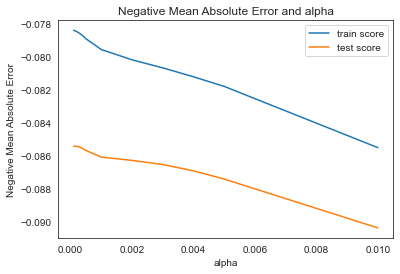

In [110]:
# plotting mean test and train scoes with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [111]:
# get the best estimator for lambda

lasso_alpha =  lasso_model_cv.best_params_.get('alpha')
lasso_alpha

0.0001

In [112]:
# check the coefficient values with lambda = 0.0002

lasso = Lasso(alpha=lasso_alpha)
        
lasso.fit(X_train, y_train) 
print("Intercept: ", ridge.intercept_)
print("Coefficients:\n",ridge.coef_)

Intercept:  11.9955548598945
Coefficients:
 [-0.01826986  0.02442684  0.0660134   0.04677461  0.02581262  0.04711394
  0.10076751  0.00918653  0.01237762  0.02048561  0.02349987  0.03732977
  0.00956827 -0.00897897 -0.01885929  0.01528937  0.01172859  0.01654298
  0.00863071  0.02038533  0.01252426  0.01625863  0.00798248  0.06576946
  0.02606051  0.10621065  0.07897993  0.02527397 -0.0113355  -0.00857021
 -0.012204    0.02270236 -0.01587817 -0.01206467  0.01863022 -0.0101833
  0.00548748 -0.00207892 -0.03104741 -0.04062535 -0.02840223 -0.00207892
  0.03303882 -0.00315356  0.03497461  0.0213992   0.01854052  0.04696472
  0.01799807 -0.00982787]


In [113]:
# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

0.013850237492186763

In [114]:
# Making predictions for train and test sets: Lasso Regression Model
y_pred_train_l = lasso.predict(X_train)
y_pred_test_l = lasso.predict(X_test)

# R2 score for Lasso Regression Model
r2_score_lasso_train = r2_score(y_true= y_train, y_pred= y_pred_train_l)
r2_score_lasso_test = r2_score(y_true= y_test, y_pred= y_pred_test_l)

# Check the mean squared error (MSE) for Lasso Regression Model
MSE_lasso_train = mean_squared_error(y_train, y_pred_train_l)
MSE_lasso_test = mean_squared_error(y_test, y_pred_test_l)

# Mean Absolute error for train and test sets
MAE_lasso_train = mean_absolute_error(y_train, y_pred_train_l)
MAE_lasso_test = mean_absolute_error(y_test, y_pred_test_l)

# Root Mean Squared Error for Train and Test Sets
RMSE_lasso_train = np.sqrt(MSE_lasso_train)
RMSE_lasso_test = np.sqrt(MSE_lasso_test)

print("For Lasso Regression Model\n(Original Model: alpha=0.0001):\n","-"*40)
print("\nFor Train Set:\nR2 score:",r2_score_lasso_train,"\nMSE score:",MSE_lasso_train,"\nMAE score:",MAE_lasso_train,\
     "\nRMSE score:",RMSE_lasso_train)
print("\nFor Test Set:\nR2 score:",r2_score_lasso_test,"\nMSE score:",MSE_lasso_test,"\nMAE score:",MAE_lasso_test,\
      "\nRMSE score:",RMSE_lasso_test,"\n","-"*40)

For Lasso Regression Model
(Original Model: alpha=0.0001):
 ----------------------------------------

For Train Set:
R2 score: 0.9181942256349852 
MSE score: 0.011509703143853103 
MAE score: 0.07899458578410501 
RMSE score: 0.10728328455007846

For Test Set:
R2 score: 0.9004460067890003 
MSE score: 0.013850237492186763 
MAE score: 0.08011295181374324 
RMSE score: 0.11768703196268807 
 ----------------------------------------


In [115]:
# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient
0,MSSubClass,-0.0181
1,LotArea,0.0241
2,OverallQual,0.0659
3,OverallCond,0.0466
4,BsmtFinSF1,0.0260
5,TotalBsmtSF,0.0466
6,GrLivArea,0.1020
7,BsmtFullBath,0.0091
8,FullBath,0.0116
9,HalfBath,0.0199


In [116]:
# Put the Features and Coefficients in dictionary

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict

{'MSSubClass': -0.018067142935881412,
 'LotArea': 0.024121926355558872,
 'OverallQual': 0.06590656585491443,
 'OverallCond': 0.04663317110994385,
 'BsmtFinSF1': 0.025987733806706353,
 'TotalBsmtSF': 0.04658944760150175,
 'GrLivArea': 0.10203275557788238,
 'BsmtFullBath': 0.00905550269953988,
 'FullBath': 0.01160666754251246,
 'HalfBath': 0.019900097480274194,
 'Fireplaces': 0.023236670574652125,
 'GarageArea': 0.03764427971784177,
 'WoodDeckSF': 0.009542739279619529,
 'IsRemodelled': -0.008955704449942304,
 'BuiltOrRemodelAge': -0.018789712844355554,
 'OldOrNewGarage': 0.015315312655726523,
 'd_BsmtQual': 0.012009445804769668,
 'd_BsmtExposure': 0.016703747539595828,
 'd_BsmtFinType1': 0.008394530920689328,
 'd_HeatingQC': 0.020175819402758945,
 'd_KitchenQual': 0.012230341674228103,
 'd_GarageFinish': 0.016493200693588467,
 'd_HouseStyle': 0.007566390272385108,
 'MSZoning_FV': 0.07361502840426049,
 'MSZoning_RH': 0.02998762826636351,
 'MSZoning_RL': 0.12174933295410588,
 'MSZoning_RM'

In [117]:
# Do an RFE to minimise the features to 15

X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

# running RFE

rfe = RFE(lm, n_features_to_select=15)            
rfe = rfe.fit(X_train_lasso, y_train)

In [118]:
# Method to get the coefficient values

def find(x):
    return lasso_coeff_dict[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

top10_lasso_df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
top10_lasso_df = top10_lasso_df.loc[top10_lasso_df['rfe_support'] == True]
top10_lasso_df.reset_index(drop=True, inplace=True)

top10_lasso_df['Coefficient'] = top10_lasso_df['Features'].apply(find)
top10_lasso_df = top10_lasso_df.sort_values(by=['Coefficient'], ascending=False)
top10_lasso_df = top10_lasso_df.head(10)
top10_lasso_df

,Features,rfe_support,rfe_ranking,Coefficient
10,MSZoning_RL,True,1,0.121749
4,GrLivArea,True,1,0.102033
11,MSZoning_RM,True,1,0.091502
8,MSZoning_FV,True,1,0.073615
0,OverallQual,True,1,0.065907
14,Foundation_PConc,True,1,0.046756
1,OverallCond,True,1,0.046633
3,TotalBsmtSF,True,1,0.046589
6,GarageArea,True,1,0.037644
13,Exterior2nd_CmentBd,True,1,0.032920


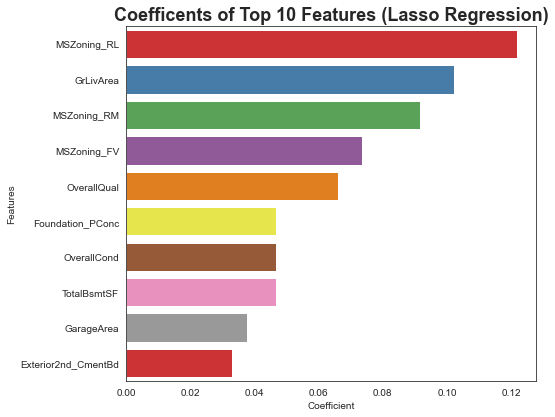

In [119]:
# bar plot to determine the variables that would affect pricing most using lasso regression

plt.figure(figsize=(25,30))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = top10_lasso_df)
plt.title('Coefficents of Top 10 Features (Lasso Regression)', fontsize=18,fontweight='bold')

plt.show()

    The chart mentioned above displays the Top 10 predictors based on the Ridge Regression model, that are significant in predicting the sale price of the house.

In [120]:
# Creating the list of top 5 features from Lasso Regression Model which we will be using later to answer 'Question 3'

top5_original_lasso_features = list(top10_lasso_df['Features'].iloc[0:5])
top5_original_lasso_features

['MSZoning_RL', 'GrLivArea', 'MSZoning_RM', 'MSZoning_FV', 'OverallQual']

### Residual Analysis of Model

    Checking for the error terms distribution. They should be normally distributed (as it is one of the major assumptions of linear regression).

#### For Train Set:

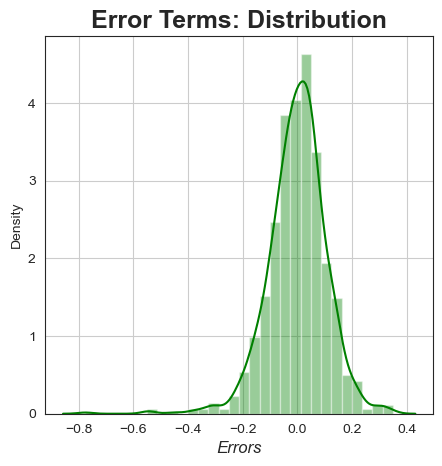

In [121]:
# Plot the histogram of the error terms
sns.set_style('white')
plt.figure(figsize=(5,5), dpi=100)
res1 = (y_train - y_pred_train_l)     #residuals
sns.distplot(res1 , bins = 30, color='g')
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
plt.grid(True)
plt.show()

#### Observation:

    Error terms seem to be approximately normally distributed with mean 0, so our assumption holds true.

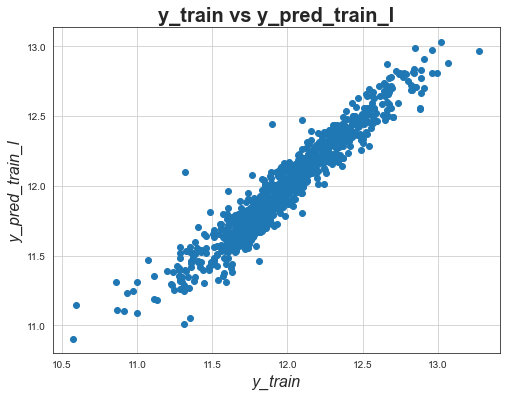

In [122]:
# Plotting y_train and y_train_pred to understand the spread.
sns.set_style('white')
plt.figure(figsize = (8,6))
plt.scatter(y_train,y_pred_train_l)
plt.title('y_train vs y_pred_train_l', fontweight='bold', fontsize = 20)           
plt.xlabel('y_train', fontstyle='italic', fontsize = 16)              
plt.ylabel('y_pred_train_l', fontstyle='italic', fontsize = 16) 
plt.grid(True)
plt.show()

In [123]:
y_train.shape

(950,)

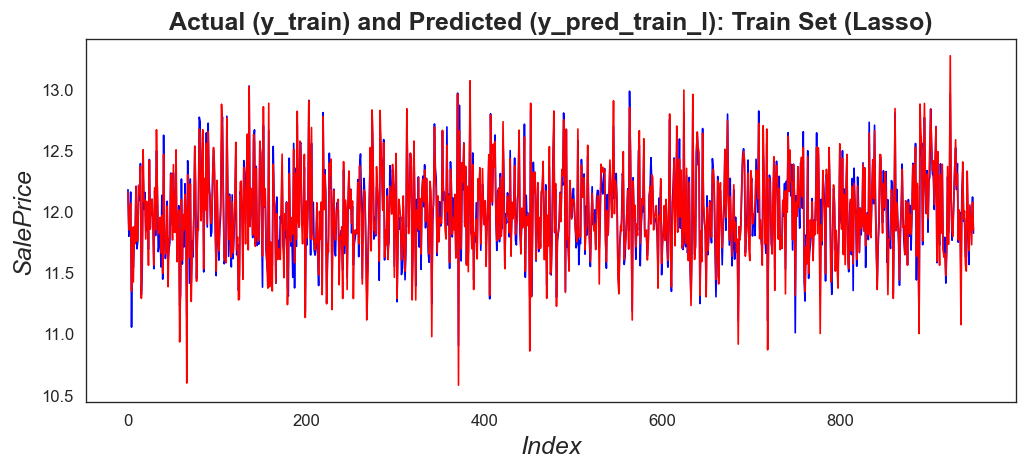

In [124]:
# Actual and Predicted (Train Set)
sns.set_style('white')
plt.figure(figsize = (10,4), dpi=120)
f1 = [i for i in range(0,950,1)] #Since y_train has 950 observations
g1 = [i for i in range(0,950,1)]
plt.plot(f1, y_pred_train_l, color="blue", linewidth=1, linestyle="-")     #Predicted 'y_pred_train_l' plot
plt.plot(g1, y_train, color="red",  linewidth=1, linestyle="-")  #Actual 'y_train' plot
plt.title("Actual (y_train) and Predicted (y_pred_train_l): Train Set (Lasso)", fontsize=15, fontweight='bold')    
plt.xlabel('Index', fontsize=15, fontstyle='italic')                              
plt.ylabel('SalePrice', fontsize=15, fontstyle='italic')  
plt.show()

- <span style="color:red">Red: Actual (y_train)</span>
- <span style="color:blue">Blue: Predicted (y_pred_train_r)</span>



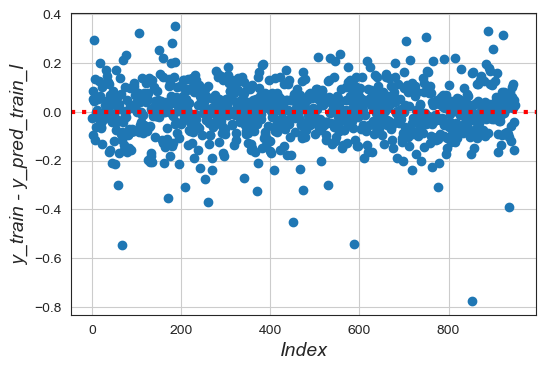

In [125]:
# Error terms for train set
sns.set_style('white')
plt.figure(figsize = (6,4), dpi=100)
j1 = [i for i in range(0,950,1)] #For 950 observations in the train set
res_train1 = (y_train-y_pred_train_l) #residuals (train set)
plt.scatter(j1, res_train1)
plt.axhline(y=0, color='r', linestyle=':', linewidth = 3)

plt.xlabel('Index', fontstyle='italic', fontsize=14)                      
plt.ylabel('y_train - y_pred_train_l', fontstyle='italic', fontsize=14)   
plt.grid(True)
plt.show()

#### Observation:
    The residuals are scattered along (y=0) and are independent of each other.

#### For Test Set:

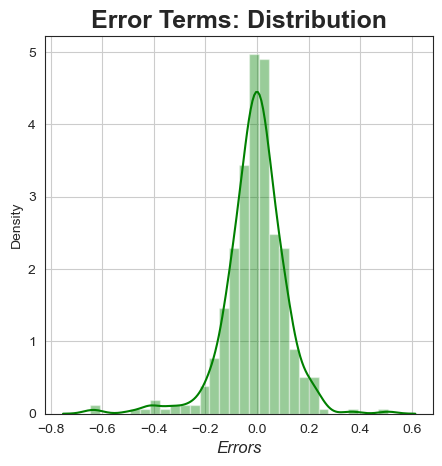

In [126]:
# Plot the histogram of the error terms
sns.set_style('white')
plt.figure(figsize=(5,5), dpi=100)
res1 = (y_test - y_pred_test_l)     #residuals
sns.distplot(res1 , bins = 30, color='g')
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
plt.grid(True)
plt.show()

#### Observation:

    Error terms seem to be approximately normally distributed with mean 0, so our assumption holds true.

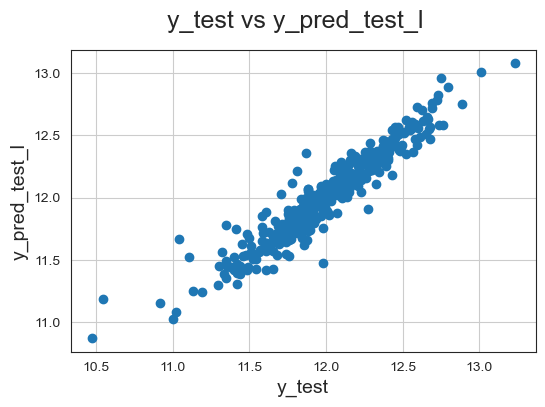

In [127]:
# Plotting y_test and y_pred_test_l to understand the spread.
sns.set_style('white')
fig = plt.figure(figsize=(6,4), dpi=100)
plt.scatter(y_test,y_pred_test_l)
fig.suptitle('y_test vs y_pred_test_l', fontsize=18)             
plt.xlabel('y_test', fontsize=14)                       
plt.ylabel('y_pred_test_l', fontsize=14)  
plt.grid(True)
plt.show()

In [128]:
y_test.shape

(408,)

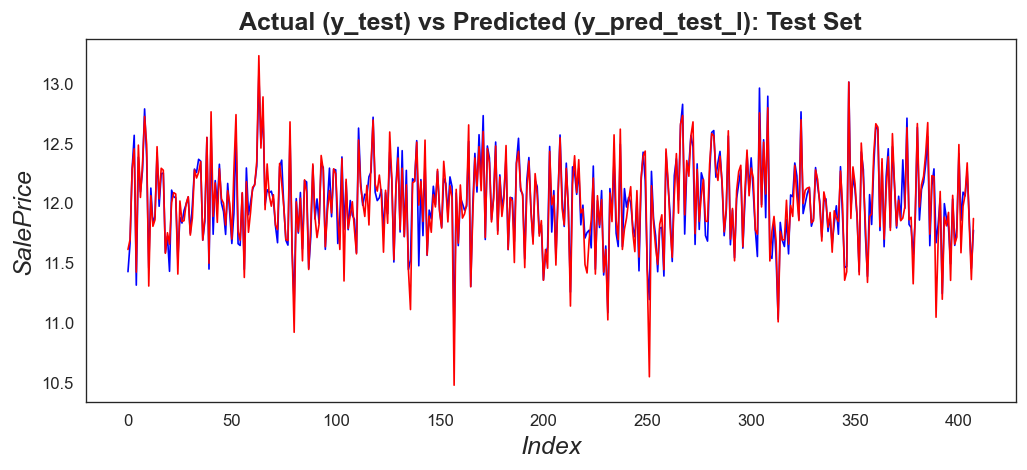

In [129]:
# Actual vs Predicted (Test Set)
plt.figure(figsize = (10,4), dpi=120)
p2 = [i for i in range(0,408,1)] #As test set has 408 observations
l2 = [i for i in range(0,408,1)]
plt.plot(p2, y_pred_test_l, color="blue", linewidth=1, linestyle="-")   #Predicted 'y_pred_test_l' plot(test pred)
plt.plot(l2, y_test, color="red",  linewidth=1, linestyle="-")   #Actual 'y_test' plot
plt.title('Actual (y_test) vs Predicted (y_pred_test_l): Test Set', fontsize=15, fontweight='bold')                              
plt.ylabel('SalePrice', fontsize=15, fontstyle='italic')  
plt.xlabel('Index', fontsize=15, fontstyle='italic')
plt.show()

- <span style="color:red">Red: Actual (y_test)</span>
- <span style="color:blue">Blue: Predicted (y_pred_test_r)</span>

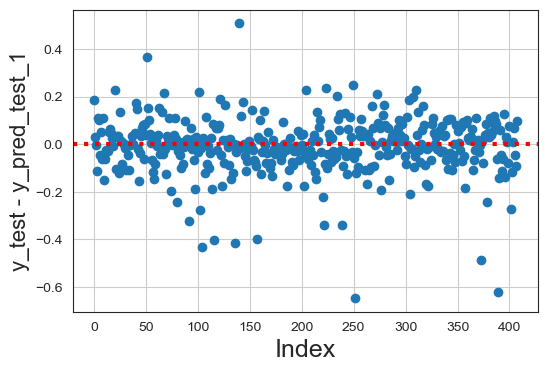

In [130]:
# Error terms
fig = plt.figure(figsize=(6,4), dpi=100)
o1 = [i for i in range(0,408,1)] #For 408 observations in the test set
res_test1 = (y_test-y_pred_test_l) #residuals test set
plt.scatter(o1,res_test1)

plt.axhline(y=0, color='r', linestyle=':', linewidth = 3)

plt.xlabel('Index', fontsize=18)                     
plt.ylabel('y_test - y_pred_test_1', fontsize=16)    
plt.grid(True)
plt.show()

#### Observation:
    The residuals are scattered along (y=0) and are independent of each other.

## Conclusion :

The optimal lambda value in case of Ridge and Lasso is as below:

    The computed optimal value of alpha for Ridge Regression (Original Model): 3.0

    The computed optimal value of alpha for Lasso Regression (Original Model): 0.0001

The Mean Squared error in case of Ridge and Lasso are:

    MSE (Test) Ridge Regression:  0.01391

    MSE (Test) Lasso Regression:  0.01385

The Mean Squared Error of Lasso is slightly lower than that of Ridge

Also, since Lasso helps in feature reduction, Lasso has a better edge over Ridge.

Hence based on Lasso, the factors that generally affect the price are the Zoning classification, Living area square feet, Overall quality and condition of the house, Foundation type of the house, Garage area, Total basement area in square feet and the Basement finished square feet area.

Therefore, the variables predicted by Lasso <B>['MSZoning_RL', 'GrLivArea', 'MSZoning_RM', MSZoning_FV', OverallQual', 'TotalBsmtSF', 'Foundation_PConc', 'OverallCond', 'GarageArea', 'Exterior2nd_CmentBd'] </B> are significant variables for predicting the price of a house.

<span style="font-size:25px;color:green">Subjective Questions Exercise:</span> 

### Question 1

    What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?



- Optimal Value of alpha for ridge and lasso regression ( values already computed previously )

        optimal_alpha_ridge = 3.0  #(Computed Above: For Ridge Regression)
        optimal_alpha_lasso = 0.0001 #(Computed Above: For Lasso Regression)

- Changes to the model when we double the value of alpha for both ridge and lasso regression

#### Ridge Regression : (Doubled alpha model, alpha =  6)

In [131]:
# Checking the outcome: coefficient values with double the value of alpha = 3*2 = 6

doubled_ridge_alpha = ridge_alpha * 2

print("Using Doubled Alpha: ", doubled_ridge_alpha)

ridge = Ridge(alpha=ridge_alpha*2)

ridge.fit(X_train, y_train)

print("Intercept: ", ridge.intercept_)
print("Coefficients:\n",ridge.coef_)

Using Doubled Alpha:  6.0
Intercept:  11.995559927414963
Coefficients:
 [-0.01828206  0.02462934  0.06656495  0.04675425  0.02576151  0.04749461
  0.09958908  0.0091787   0.01288135  0.02095049  0.0238195   0.03710232
  0.00953644 -0.00898414 -0.01905768  0.0150502   0.01136814  0.01646654
  0.00873146  0.02044792  0.01290471  0.01604104  0.00804514  0.05728513
  0.02168301  0.08962061  0.06514415  0.02504119 -0.01130056 -0.01049903
 -0.01242716  0.02237767 -0.01622    -0.01190651  0.01842727 -0.01012294
  0.00551002 -0.00201929 -0.0258623  -0.03573656 -0.02721752 -0.00201929
  0.02810468 -0.00303685  0.03028059  0.02045448  0.01807208  0.04640611
  0.01800101 -0.01005159]


In [132]:
# Making predictions for train and test sets: Ridge Regression Model
y_pred_train_r = ridge.predict(X_train)
y_pred_test_r = ridge.predict(X_test)

# R2 score for Ridge Regression Model
r2_score_ridge_train = r2_score(y_true= y_train, y_pred= y_pred_train_r)
r2_score_ridge_test = r2_score(y_true= y_test, y_pred= y_pred_test_r)

# Check the mean squared error (MSE) for Ridge Regression Model
MSE_ridge_train = mean_squared_error(y_train, y_pred_train_r)
MSE_ridge_test = mean_squared_error(y_test, y_pred_test_r)

# Mean Absolute error for train and test sets
MAE_ridge_train = mean_absolute_error(y_train, y_pred_train_r)
MAE_ridge_test = mean_absolute_error(y_test, y_pred_test_r)

# Root Mean Squared Error for Train and Test Sets
RMSE_ridge_train = np.sqrt(MSE_ridge_train)
RMSE_ridge_test = np.sqrt(MSE_ridge_test)


print("For Ridge Regression Model\n(Doubled alpha model, alpha = 3*2 = 6):\n","-"*65)
print("\nFor Train Set:\nR2 score:",r2_score_ridge_train,"\nMSE score:",MSE_ridge_train,"\nMAE score:",MAE_ridge_train,\
     "\nRMSE score:",RMSE_ridge_train)
print("\nFor Test Set:\nR2 score:",r2_score_ridge_test,"\nMSE score:",MSE_ridge_test,"\nMAE score:",MAE_ridge_test,\
      "\nRMSE score:",RMSE_ridge_test,"\n","-"*65)

For Ridge Regression Model
(Doubled alpha model, alpha = 3*2 = 6):
 -----------------------------------------------------------------

For Train Set:
R2 score: 0.9178295902600888 
MSE score: 0.011561005694967397 
MAE score: 0.07922248113596868 
RMSE score: 0.10752211723625701

For Test Set:
R2 score: 0.8999642581769162 
MSE score: 0.013917259742863885 
MAE score: 0.08047387138123295 
RMSE score: 0.11797143613122578 
 -----------------------------------------------------------------


In [133]:
# Put the Features and coefficienst in a dataframe

ridge_df_1 = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df_1.reset_index(drop=True, inplace=True)
ridge_df_1


,Features,Coefficient
0,MSSubClass,-0.0183
1,LotArea,0.0246
2,OverallQual,0.0666
3,OverallCond,0.0468
4,BsmtFinSF1,0.0258
5,TotalBsmtSF,0.0475
6,GrLivArea,0.0996
7,BsmtFullBath,0.0092
8,FullBath,0.0129
9,HalfBath,0.0210


In [134]:
# Assign the Features and their coefficient values to a dictionary which would be used while plotting the bar plot

ridge_coeff_dict_1 = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))
ridge_coeff_dict_1

{'MSSubClass': -0.0183,
 'LotArea': 0.0246,
 'OverallQual': 0.0666,
 'OverallCond': 0.0468,
 'BsmtFinSF1': 0.0258,
 'TotalBsmtSF': 0.0475,
 'GrLivArea': 0.0996,
 'BsmtFullBath': 0.0092,
 'FullBath': 0.0129,
 'HalfBath': 0.021,
 'Fireplaces': 0.0238,
 'GarageArea': 0.0371,
 'WoodDeckSF': 0.0095,
 'IsRemodelled': -0.009,
 'BuiltOrRemodelAge': -0.0191,
 'OldOrNewGarage': 0.0151,
 'd_BsmtQual': 0.0114,
 'd_BsmtExposure': 0.0165,
 'd_BsmtFinType1': 0.0087,
 'd_HeatingQC': 0.0204,
 'd_KitchenQual': 0.0129,
 'd_GarageFinish': 0.016,
 'd_HouseStyle': 0.008,
 'MSZoning_FV': 0.0573,
 'MSZoning_RH': 0.0217,
 'MSZoning_RL': 0.0896,
 'MSZoning_RM': 0.0651,
 'Neighborhood_Crawfor': 0.025,
 'Neighborhood_Edwards': -0.0113,
 'Neighborhood_IDOTRR': -0.0105,
 'Neighborhood_MeadowV': -0.0124,
 'Neighborhood_NridgHt': 0.0224,
 'Neighborhood_OldTown': -0.0162,
 'Neighborhood_SWISU': -0.0119,
 'Neighborhood_StoneBr': 0.0184,
 'Exterior1st_BrkComm': -0.0101,
 'Exterior1st_BrkFace': 0.0055,
 'Exterior1st_CBlo

In [135]:
# Do an RFE to minimise the features to 15
X_train_ridge_1 = X_train[ridge_df_1.Features]

lm = LinearRegression()
lm.fit(X_train_ridge_1, y_train)

# running RFE
rfe = RFE(lm, n_features_to_select=15)            
rfe = rfe.fit(X_train_ridge_1, y_train)

In [136]:
# Method to get the coefficient values

def find(x):
    return ridge_coeff_dict_1[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

top10_ridge_df_1 = pd.DataFrame(list(zip( X_train_ridge_1.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
top10_ridge_df_1 = top10_ridge_df_1.loc[top10_ridge_df_1['rfe_support'] == True]
top10_ridge_df_1.reset_index(drop=True, inplace=True)

top10_ridge_df_1['Coefficient'] = top10_ridge_df_1['Features'].apply(find)
top10_ridge_df_1 = top10_ridge_df_1.sort_values(by=['Coefficient'], ascending=False)
top10_ridge_df_1 = top10_ridge_df_1.head(10)
top10_ridge_df_1


,Features,rfe_support,rfe_ranking,Coefficient
4,GrLivArea,True,1,0.0996
10,MSZoning_RL,True,1,0.0896
0,OverallQual,True,1,0.0666
11,MSZoning_RM,True,1,0.0651
8,MSZoning_FV,True,1,0.0573
3,TotalBsmtSF,True,1,0.0475
1,OverallCond,True,1,0.0468
14,Foundation_PConc,True,1,0.0464
6,GarageArea,True,1,0.0371
13,Exterior2nd_CmentBd,True,1,0.0281


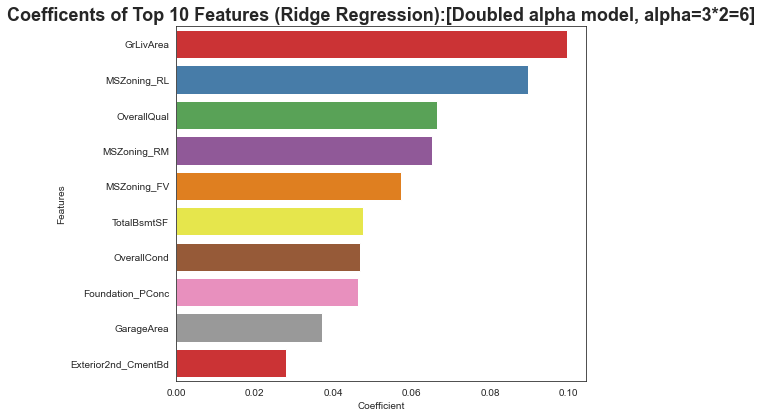

In [137]:
# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(25,30))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = top10_ridge_df_1)
plt.title('Coefficents of Top 10 Features (Ridge Regression):[Doubled alpha model, alpha=3*2=6]', 
          fontsize=18,fontweight='bold')

plt.show()

In [138]:
print("For Ridge Regression (Doubled alpha model, alpha = 3*2 = 6): \n","-"*110)
print("The most important top10 predictor variables after the change is implemented are as follows:\n\n",\
      list(top10_ridge_df_1['Features']),"\n", "-"*110)

For Ridge Regression (Doubled alpha model, alpha = 3*2 = 6): 
 --------------------------------------------------------------------------------------------------------------
The most important top10 predictor variables after the change is implemented are as follows:

 ['GrLivArea', 'MSZoning_RL', 'OverallQual', 'MSZoning_RM', 'MSZoning_FV', 'TotalBsmtSF', 'OverallCond', 'Foundation_PConc', 'GarageArea', 'Exterior2nd_CmentBd'] 
 --------------------------------------------------------------------------------------------------------------


#### Lasso Regression: (Doubled alpha model, alpha = 0.0002)

In [139]:
# Checking the outcome: coefficient values with double the value of alpha = 0.0001*2 = 0.0002 (For Lasso Regression)

doubled_lasso_alpha = lasso_alpha * 2

print("Using doubled lasso alpha: ", doubled_lasso_alpha)

lasso = Lasso(alpha=doubled_lasso_alpha)
        
lasso.fit(X_train, y_train)

print("Intercept: ", lasso.intercept_)
print("Coefficients:\n ", lasso.coef_)

Using doubled lasso alpha:  0.0002
Intercept:  11.995570160258625
Coefficients:
  [-0.0179291   0.02409309  0.06671257  0.04659178  0.0260826   0.04667358
  0.10183586  0.00892125  0.01144777  0.01993496  0.02337412  0.03757493
  0.00946817 -0.00893818 -0.01896348  0.01504672  0.01170122  0.01674683
  0.00830641  0.02008386  0.01237031  0.01639525  0.00725621  0.068967
  0.02746772  0.11277882  0.08364244  0.0249894  -0.01109839 -0.00756902
 -0.01179677  0.02223378 -0.01550491 -0.0119121   0.01814236 -0.01010924
  0.00543178 -0.00315863 -0.02334784 -0.0365835  -0.02749324 -0.00092021
  0.02554298 -0.00317303  0.0310718   0.02015358  0.01760887  0.04617697
  0.01735558 -0.00952723]


In [140]:
# Making predictions for test and train sets: Lasso Regression Model
y_pred_train_l = lasso.predict(X_train)
y_pred_test_l = lasso.predict(X_test)

# R2 score for Lasso Regression Model
r2_score_lasso_train = r2_score(y_true= y_train, y_pred= y_pred_train_l)
r2_score_lasso_test = r2_score(y_true= y_test, y_pred= y_pred_test_l)

# Check the mean squared error (MSE) for Lasso Regression Model
MSE_lasso_train = mean_squared_error(y_train, y_pred_train_l)
MSE_lasso_test = mean_squared_error(y_test, y_pred_test_l)

# Mean Absolute error for train and test sets
MAE_lasso_train = mean_absolute_error(y_train, y_pred_train_l)
MAE_lasso_test = mean_absolute_error(y_test, y_pred_test_l)

# Root Mean Squared Error for Train and Test Sets
RMSE_lasso_train = np.sqrt(MSE_lasso_train)
RMSE_lasso_test = np.sqrt(MSE_lasso_test)

print("For Lasso Regression Model:\n(Doubled alpha model: alpha:0.0001*2 = 0.0002)\n","-"*70)
print("\nFor Train Set:\nR2 score:",r2_score_lasso_train,"\nMSE score:",MSE_lasso_train,"\nMAE score:",MAE_lasso_train,\
     "\nRMSE score:",RMSE_lasso_train)
print("\nFor Test Set:\nR2 score:",r2_score_lasso_test,"\nMSE score:",MSE_lasso_test,"\nMAE score:",MAE_lasso_test,\
      "\nRMSE score:",RMSE_lasso_test,"\n","-"*70)

For Lasso Regression Model:
(Doubled alpha model: alpha:0.0001*2 = 0.0002)
 ----------------------------------------------------------------------

For Train Set:
R2 score: 0.9180766869812588 
MSE score: 0.011526240301808285 
MAE score: 0.0790901771714888 
RMSE score: 0.10736032927393752

For Test Set:
R2 score: 0.9008830204072753 
MSE score: 0.013789438902344154 
MAE score: 0.079947254083032 
RMSE score: 0.11742844162443847 
 ----------------------------------------------------------------------


In [141]:
# Put the shortlisted Features and coefficienst in a dataframe

lasso_df_1 = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df_1 = lasso_df_1[lasso_df_1['Coefficient'] != 0.00]
lasso_df_1.reset_index(drop=True, inplace=True)
lasso_df_1

,Features,Coefficient
0,MSSubClass,-0.0179
1,LotArea,0.0241
2,OverallQual,0.0667
3,OverallCond,0.0466
4,BsmtFinSF1,0.0261
5,TotalBsmtSF,0.0467
6,GrLivArea,0.1018
7,BsmtFullBath,0.0089
8,FullBath,0.0114
9,HalfBath,0.0199


In [142]:
# Put the Features and Coefficients in dictionary

lasso_coeff_dict_1 = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict_1

{'MSSubClass': -0.01792909878248413,
 'LotArea': 0.024093094869724597,
 'OverallQual': 0.0667125669371562,
 'OverallCond': 0.04659177948280228,
 'BsmtFinSF1': 0.02608260079210023,
 'TotalBsmtSF': 0.04667358154312144,
 'GrLivArea': 0.10183585865341171,
 'BsmtFullBath': 0.008921245284464169,
 'FullBath': 0.011447772011830702,
 'HalfBath': 0.019934955108301844,
 'Fireplaces': 0.023374117750083127,
 'GarageArea': 0.03757492993211669,
 'WoodDeckSF': 0.009468170037951182,
 'IsRemodelled': -0.008938175664782057,
 'BuiltOrRemodelAge': -0.018963481051186996,
 'OldOrNewGarage': 0.015046718427133121,
 'd_BsmtQual': 0.011701224889419194,
 'd_BsmtExposure': 0.016746826755213877,
 'd_BsmtFinType1': 0.008306405445824571,
 'd_HeatingQC': 0.020083863873423393,
 'd_KitchenQual': 0.012370313178693365,
 'd_GarageFinish': 0.01639525276761292,
 'd_HouseStyle': 0.007256210779084362,
 'MSZoning_FV': 0.06896700284071261,
 'MSZoning_RH': 0.027467721126062595,
 'MSZoning_RL': 0.1127788248974735,
 'MSZoning_RM': 

In [143]:
# Do an RFE to minimise the features to 15

X_train_lasso_1 = X_train[lasso_df_1.Features]

lm = LinearRegression()
lm.fit(X_train_lasso_1, y_train)

# running RFE

rfe = RFE(lm, n_features_to_select=15)            
rfe = rfe.fit(X_train_lasso_1, y_train)

In [144]:
# Method to get the coefficient values

def find(x):
    return lasso_coeff_dict_1[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

top10_lasso_df_1 = pd.DataFrame(list(zip( X_train_lasso_1.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
top10_lasso_df_1 = top10_lasso_df_1.loc[top10_lasso_df_1['rfe_support'] == True]
top10_lasso_df_1.reset_index(drop=True, inplace=True)

top10_lasso_df_1['Coefficient'] = top10_lasso_df_1['Features'].apply(find)
top10_lasso_df_1 = top10_lasso_df_1.sort_values(by=['Coefficient'], ascending=False)
top10_lasso_df_1 = top10_lasso_df_1.head(10)
top10_lasso_df_1


,Features,rfe_support,rfe_ranking,Coefficient
10,MSZoning_RL,True,1,0.112779
4,GrLivArea,True,1,0.101836
11,MSZoning_RM,True,1,0.083642
8,MSZoning_FV,True,1,0.068967
0,OverallQual,True,1,0.066713
3,TotalBsmtSF,True,1,0.046674
1,OverallCond,True,1,0.046592
14,Foundation_PConc,True,1,0.046177
6,GarageArea,True,1,0.037575
9,MSZoning_RH,True,1,0.027468


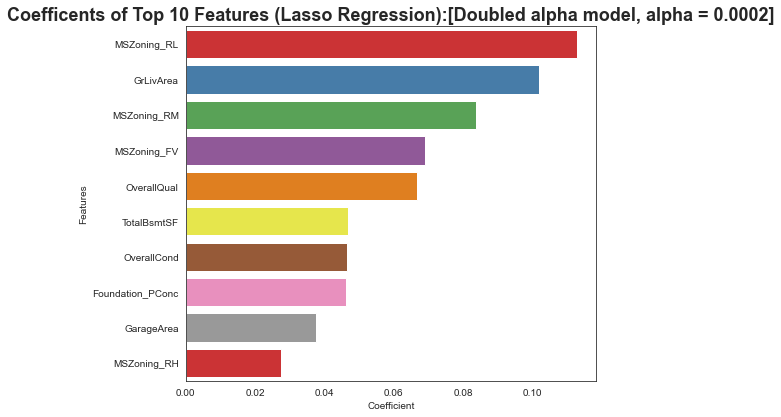

In [145]:
# bar plot to determine the variables that would affect pricing most using lasso regression

plt.figure(figsize=(25,30))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = top10_lasso_df_1)
plt.title('Coefficents of Top 10 Features (Lasso Regression):[Doubled alpha model, alpha = 0.0002]', fontsize=18,fontweight='bold')

plt.show()


In [146]:
print("For Lasso Regression (Doubled alpha model: alpha:0.0001*2 = 0.0002): \n","-"*110)
print("The most important top10 predictor variables after the change is implemented are as follows:\n\n",\
      list(top10_lasso_df_1['Features']),"\n", "-"*110)

For Lasso Regression (Doubled alpha model: alpha:0.0001*2 = 0.0002): 
 --------------------------------------------------------------------------------------------------------------
The most important top10 predictor variables after the change is implemented are as follows:

 ['MSZoning_RL', 'GrLivArea', 'MSZoning_RM', 'MSZoning_FV', 'OverallQual', 'TotalBsmtSF', 'OverallCond', 'Foundation_PConc', 'GarageArea', 'MSZoning_RH'] 
 --------------------------------------------------------------------------------------------------------------


### Question 2

    You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?

    (Solution provided in the Subjective Questions pdf File)

### Question 3

    After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [147]:
# From Original Lasso Regression Model, import 'top5_original_lasso_features'
print("Top 5 features in original lasso model:\n", top5_original_lasso_features)

df = house_data_copy

# Removing these top5 features (as per Original Lasso Model) from 'df'
df= df.drop(top5_original_lasso_features, axis=1)
df.head()

Top 5 features in original lasso model:
 ['MSZoning_RL', 'GrLivArea', 'MSZoning_RM', 'MSZoning_FV', 'OverallQual']


,MSSubClass,LotFrontage,LotArea,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_HouseStyle,d_LotConfig,d_MasVnrType,MSZoning_RH,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,65.0,8450,5,196.0,706,150,856,1,2,1,3,0,548,0,61,12.247699,0,5,1,3,4,4,1,6,5,4,0,2,4,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,20,80.0,9600,8,0.0,978,284,1262,0,2,0,3,1,460,298,0,12.109016,0,31,0,3,3,4,4,5,5,3,3,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,60,68.0,11250,5,162.0,486,434,920,1,2,1,3,1,608,0,42,12.317171,1,6,1,2,4,4,2,6,5,4,3,2,4,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,70,60.0,9550,5,0.0,216,540,756,1,1,0,3,1,642,0,35,11.849405,1,36,0,2,3,3,1,5,4,4,4,1,4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,60,84.0,14260,5,350.0,655,490,1145,1,2,1,4,1,836,192,84,12.429220,0,8,1,2,4,4,3,6,5,4,3,2,4,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


In [148]:
# Creating a function to find binary value columns from the 'df' dataframe (if any)
def binary_val_cols(df):
    df_copy = df.copy()
    dualsvcol = (df_copy.nunique()==2)
    list_dualsvcol = list(dualsvcol[dualsvcol.values==True].index)
    return list_dualsvcol

binary_cols = binary_val_cols(df)

In [149]:
# split into train and test

# from sklearn.model_selection import train_test_split

np.random.seed(0)
df_train, df_test = train_test_split(df, train_size=0.7, test_size = 0.3, random_state=100)

In [150]:
# Dataframe with binary columns
df_binary_train = df_train.loc[:, binary_cols]
df_binary_test = df_test.loc[:, binary_cols]

# Dropping binary dummy variables and we shall concat them later to preserve the scale
df_train = df_train.drop(binary_cols, axis=1)
df_test = df_test.drop(binary_cols, axis=1)

# StandardScaler

# from sklearn.preprocessing import StandardScaler

all_cols =df_train.columns
scaler = StandardScaler()

# scaler fit_transform on train data
df_train[all_cols] = scaler.fit_transform(df_train[all_cols])
# concat dummies:Train set
df_train = pd.concat([df_train, df_binary_train], axis=1)

# scaler fit_transform on test data
df_test[all_cols] = scaler.transform(df_test[all_cols])
# concat dummies: Test set
df_test = pd.concat([df_test, df_binary_test], axis=1)

In [151]:
# Storing target variable to y_train and y_test respectively

y_train = df_train['SalePrice']
y_test = df_test['SalePrice']

In [152]:
# Storing all feature variables to X_train and X_test

X_train = df_train.drop('SalePrice',axis=1)
X_test = df_test.drop('SalePrice',axis=1)

#### Recursive Feature Elimination

In [153]:
# Running RFE with the output number of the variable equal to 50

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=50)
rfe = rfe.fit(X_train, y_train)

In [154]:
# my_zip file zips features, rfe.support_ and rfe.ranking_
my_zip = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
my_zip

[('MSSubClass', False, 36),
 ('LotFrontage', False, 43),
 ('LotArea', False, 6),
 ('OverallCond', True, 1),
 ('MasVnrArea', False, 40),
 ('BsmtFinSF1', False, 27),
 ('BsmtUnfSF', False, 9),
 ('TotalBsmtSF', True, 1),
 ('BsmtFullBath', False, 38),
 ('FullBath', True, 1),
 ('HalfBath', True, 1),
 ('BedroomAbvGr', False, 14),
 ('Fireplaces', False, 12),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 42),
 ('OpenPorchSF', False, 33),
 ('BuiltOrRemodelAge', False, 16),
 ('d_LotShape', False, 47),
 ('d_ExterQual', False, 23),
 ('d_BsmtQual', False, 30),
 ('d_BsmtExposure', False, 48),
 ('d_BsmtFinType1', False, 44),
 ('d_HeatingQC', False, 31),
 ('d_KitchenQual', True, 1),
 ('d_FireplaceQu', False, 29),
 ('d_GarageFinish', False, 37),
 ('d_HouseStyle', True, 1),
 ('d_LotConfig', False, 49),
 ('IsRemodelled', False, 18),
 ('OldOrNewGarage', False, 7),
 ('d_MasVnrType', False, 45),
 ('MSZoning_RH', False, 46),
 ('Neighborhood_Blueste', True, 1),
 ('Neighborhood_BrDale', True, 1),
 ('Neighbor

In [155]:
# Checking columns that have RFE support
col_rfe_sup = X_train.columns[rfe.support_]
col_rfe_sup

Index(['OverallCond', 'TotalBsmtSF', 'FullBath', 'HalfBath', 'GarageArea',
       'd_KitchenQual', 'd_HouseStyle', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
       'Neighborhood_StoneBr', 'RoofStyle_Gambrel', 'RoofStyle_Mansard',
       'RoofStyle_Shed', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior2nd_AsphShn', 'Exterior2nd_CmentBd',
       'Exterior2nd_Other', 'Exterior2nd_Stone', 'Exterior2nd_Stucco',
       'Exterior2nd_VinylSd', '

In [156]:
# Creating a dataframe for RFE supported top 50 indepedent variables. 

# Assign the 50 features selected using RFE to a dataframe and view them
top50_df = pd.DataFrame(my_zip, columns=['Features', 'rfe_support', 'rfe_ranking'])

top50_df = top50_df.loc[top50_df['rfe_support'] == True]
top50_df.reset_index(drop=True, inplace=True)

top50_df

,Features,rfe_support,rfe_ranking
0,OverallCond,True,1
1,TotalBsmtSF,True,1
2,FullBath,True,1
3,HalfBath,True,1
4,GarageArea,True,1
5,d_KitchenQual,True,1
6,d_HouseStyle,True,1
7,Neighborhood_Blueste,True,1
8,Neighborhood_BrDale,True,1
9,Neighborhood_BrkSide,True,1


In [157]:
# Assign top 50 columns to X_train_rfe

X_train_rfe = X_train[col_rfe_sup]

In [158]:
# Make sure that we have only 50 features (supported by RFE) in X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

#### Model Building: Lasso Regression Model

In [159]:
# Lasso Regression Model Building
lasso = Lasso()

# List of alphas (lambda parameter)

params = {'alpha': [0.00001, 0.00009, 0.00005, 0.00003, 0.0001, 0.0002, 0.0003, 0.0004,
                    0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.005, 0.01, 0.02, 0.05]}

# Cross-Validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 9e-05, 5e-05, 3e-05, 0.0001, 0.0002,
                                   0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
                                   0.0008, 0.0009, 0.001, 0.005, 0.01, 0.02,
                                   0.05]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [160]:
# Display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
2,0.00005,-0.266192,-0.289918,1
3,0.00003,-0.266047,-0.289943,2
0,0.00001,-0.265941,-0.290046,3
1,0.00009,-0.266555,-0.290224,4
4,0.0001,-0.266664,-0.290318,5
5,0.0002,-0.267793,-0.291135,6
6,0.0003,-0.268854,-0.291458,7
7,0.0004,-0.269978,-0.291928,8
8,0.0005,-0.271073,-0.292982,9
9,0.0006,-0.272176,-0.293802,10


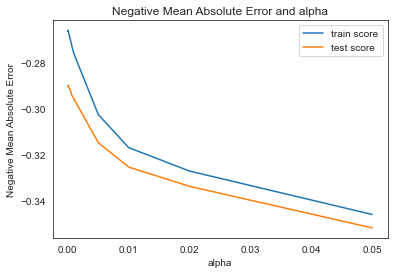

In [161]:
# Plotting mean test and train scoes with alpha 
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [162]:
# get the best estimator for lambda

lasso_alpha = lasso_model_cv.best_params_.get('alpha')
lasso_alpha

5e-05

In [163]:
# check the coefficient values with (lambda) alpha = 0.00005

lasso = Lasso(alpha=lasso_alpha)
        
lasso.fit(X_train, y_train)

print("Intercepts: ",lasso.intercept_)
print("Coefficients:\n",lasso.coef_)

Intercepts:  -0.5196318700658626
Coefficients:
 [ 0.1636058   0.37409911  0.15745824  0.16161988  0.1449949   0.12803229
  0.13558437 -0.56132493 -0.8650341  -0.30989746 -0.13797208 -0.1656828
 -0.45272395 -0.16342872 -0.76799538 -1.50151917 -0.36096547 -0.35015501
 -0.57671426 -0.27087038  0.34561052  0.30229529 -0.6247416  -0.14827947
 -0.38974188 -0.12660144  0.20359404  0.27277816  0.06508296  0.12216345
  0.94053256  0.20336128  0.25755325  0.5100287   0.42106361 -0.40363275
 -0.05904499  0.25737157  0.68557827 -0.14149629 -0.19284175  0.4021223
  0.12798912  0.39857544  0.77861824  0.6225403   0.93981086  0.65976044
  0.52245591  0.36114237]


In [164]:

# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient
0,OverallCond,0.1636
1,TotalBsmtSF,0.3741
2,FullBath,0.1575
3,HalfBath,0.1616
4,GarageArea,0.1450
5,d_KitchenQual,0.1280
6,d_HouseStyle,0.1356
7,Neighborhood_Blueste,-0.5613
8,Neighborhood_BrDale,-0.8650
9,Neighborhood_BrkSide,-0.3099


In [165]:
# Put the Features and Coefficients in dictionary

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict


{'OverallCond': 0.1636058023454788,
 'TotalBsmtSF': 0.37409910770077487,
 'FullBath': 0.157458239303911,
 'HalfBath': 0.16161987888862145,
 'GarageArea': 0.14499489767369406,
 'd_KitchenQual': 0.12803228770225464,
 'd_HouseStyle': 0.13558437020562536,
 'Neighborhood_Blueste': -0.5613249321623018,
 'Neighborhood_BrDale': -0.8650341035965736,
 'Neighborhood_BrkSide': -0.30989746432885257,
 'Neighborhood_ClearCr': -0.13797207585472965,
 'Neighborhood_CollgCr': -0.16568279890753382,
 'Neighborhood_Edwards': -0.45272395316234704,
 'Neighborhood_Gilbert': -0.16342871977172896,
 'Neighborhood_IDOTRR': -0.7679953773977768,
 'Neighborhood_MeadowV': -1.5015191731116413,
 'Neighborhood_Mitchel': -0.3609654731439561,
 'Neighborhood_NAmes': -0.3501550056841615,
 'Neighborhood_NPkVill': -0.5767142634049104,
 'Neighborhood_NWAmes': -0.2708703758227196,
 'Neighborhood_NoRidge': 0.34561051742601734,
 'Neighborhood_NridgHt': 0.3022952890274113,
 'Neighborhood_OldTown': -0.6247415987659594,
 'Neighborhoo

In [166]:
# Do an RFE to minimise the features to 15

X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

# running RFE

rfe = RFE(lm, n_features_to_select=15)            
rfe = rfe.fit(X_train_lasso, y_train)

In [167]:
# Method to get the coefficient values

def find(x):
    return lasso_coeff_dict[x]

# Assign top 5 features to a temp dataframe for further display in the bar plot

top5_lasso_df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
top5_lasso_df = top5_lasso_df.loc[top5_lasso_df['rfe_support'] == True]
top5_lasso_df.reset_index(drop=True, inplace=True)

top5_lasso_df['Coefficient'] = top5_lasso_df['Features'].apply(find)
top5_lasso_df = top5_lasso_df.sort_values(by=['Coefficient'], ascending=False)
top5_lasso_df = top5_lasso_df.head(5)
top5_lasso_df


,Features,rfe_support,rfe_ranking,Coefficient
14,Exterior2nd_Other,True,1,0.685578
12,Exterior1st_Stone,True,1,0.510029
8,Neighborhood_NoRidge,True,1,0.345611
9,Neighborhood_NridgHt,True,1,0.302295
13,Exterior2nd_CmentBd,True,1,0.257372


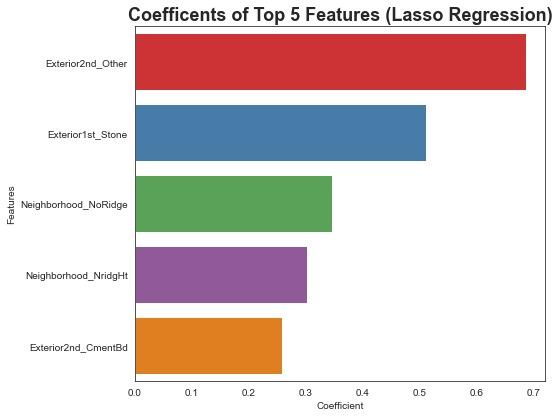

In [168]:
# bar plot to determine the top 5 variables that would affect pricing most using ridge regression

plt.figure(figsize=(25,30))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = top5_lasso_df)
plt.title('Coefficents of Top 5 Features (Lasso Regression)', fontsize=18,fontweight='bold')

plt.show()


In [169]:
print("For Lasso Regression: \n","-"*110)
print("The most important top 5 predictor variables after the change is implemented are as follows:\n\n",\
      list(top5_lasso_df['Features']),"\n", "-"*110)


For Lasso Regression: 
 --------------------------------------------------------------------------------------------------------------
The most important top 5 predictor variables after the change is implemented are as follows:

 ['Exterior2nd_Other', 'Exterior1st_Stone', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Exterior2nd_CmentBd'] 
 --------------------------------------------------------------------------------------------------------------


#### Question 4

    How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?

Solution provided in the Subjective Questions pdf file